In [1]:
from Funcs.Utility import *

In [2]:
p = os.path.join(PATH_INTERMEDIATE, 'calorie_count_binary_personal-15min.pkl')
X, y, groups, t, datetimes = load(p)

In [3]:
X

,PIF#participationStartTimestamp,PIF#age,PIF#openness,PIF#conscientiousness,PIF#neuroticism,PIF#extraversion,PIF#agreeableness,PIF#GHQ12,PIF#PSS10,PIF#CESD-R,...,PWR#RLV_SUP_TodayAfternoon,PWR#ETP#_TodayLateAfternoon,PWR#ASC#_TodayLateAfternoon,PWR#RLV_SUP_TodayLateAfternoon,PWR#ETP#_TodayEvening,PWR#ASC#_TodayEvening,PWR#RLV_SUP_TodayEvening,PWR#ETP#_TodayNight,PWR#ASC#_TodayNight,PWR#RLV_SUP_TodayNight
0,1.637712e+12,23.0,11.0,12.0,3.0,10.0,9.0,9.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.637712e+12,23.0,11.0,12.0,3.0,10.0,9.0,9.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.637712e+12,23.0,11.0,12.0,3.0,10.0,9.0,9.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.637712e+12,23.0,11.0,12.0,3.0,10.0,9.0,9.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.637712e+12,23.0,11.0,12.0,3.0,10.0,9.0,9.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21614,1.638922e+12,20.0,10.0,8.0,4.0,7.0,14.0,7.0,12.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21615,1.638922e+12,20.0,10.0,8.0,4.0,7.0,14.0,7.0,12.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21616,1.638922e+12,20.0,10.0,8.0,4.0,7.0,14.0,7.0,12.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21617,1.638922e+12,20.0,10.0,8.0,4.0,7.0,14.0,7.0,12.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#Divide the features into different categories
feat_current = X.loc[:,[('#VAL' in str(x)) or ('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_dsc = X.loc[:,[('#DSC' in str(x))  for x in X.keys()]]  
feat_yesterday = X.loc[:,[('Yesterday' in str(x))  for x in X.keys()]]  
feat_today = X.loc[:,[('Today' in str(x))  for x in X.keys()]]  
feat_sleep = X.loc[:,[('Sleep' in str(x))  for x in X.keys()]]  
feat_time = X.loc[:,[('Time' in str(x))  for x in X.keys()]]  
feat_pif = X.loc[:,[('PIF' in str(x))  for x in X.keys()]]  
feat_ImmediatePast = X.loc[:,[('ImmediatePast_15' in str(x))  for x in X.keys()]]
#Divide the time window features into sensor/past stress label
feat_current_sensor = X.loc[:,[('#VAL' in str(x))  for x in X.keys()]]  
feat_current_ESM = X.loc[:,[('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_ImmediatePast_sensor = feat_ImmediatePast.loc[:,[('ESM' not in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_ImmediatePast_ESM = feat_ImmediatePast.loc[:,[('ESM'  in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_today_sensor = feat_today.loc[:,[('ESM' not in str(x))  for x in feat_today.keys()]]  
feat_today_ESM = feat_today.loc[:,[('ESM'  in str(x)) for x in feat_today.keys()]]  
feat_yesterday_sensor = feat_yesterday.loc[:,[('ESM' not in str(x)) for x in feat_yesterday.keys()]]  
feat_yesterday_ESM = feat_yesterday.loc[:,[('ESM'  in str(x)) for x in feat_yesterday.keys()]]

In [5]:
feat_baseline = pd.concat([ feat_time,feat_dsc,feat_current_sensor, feat_ImmediatePast_sensor],axis=1)
feat_final = pd.concat([feat_baseline  ], axis=1)
# # Fill NaN values with zeros
feat_final = feat_final.fillna(0)
X = feat_final
cats = X.columns[X.dtypes == bool]

In [6]:
X = X.loc[:, ~X.columns.str.startswith(('SCR', 'PWR', 'CHG', 'BAT','LOC'))]

In [7]:
cn = X.columns.tolist()
print(cn)

['PIF#participationStartTimestamp', 'Time#DOW=MON', 'Time#DOW=TUE', 'Time#DOW=WED', 'Time#DOW=THU', 'Time#DOW=FRI', 'Time#DOW=SAT', 'Time#DOW=SUN', 'Time#WKD=Y', 'Time#WKD=N', 'Time#HRN=DAWN', 'Time#HRN=MORNING', 'Time#HRN=AFTERNOON', 'Time#HRN=LATE_AFTERNOON', 'Time#HRN=EVENING', 'Time#HRN=NIGHT', 'Time#HRN=MIDNIGHT', 'APP_CAT#DSC', 'APP_CAT#DSC=UNKNOWNSYSTEMENTERSOCIALHEALTHWORKINFO', 'CALL_CNT#DSC', 'CALL_CNT#DSC=UNKNOWNMOBILEOTHERWORKHOMEUNDEFINEDMAIN', 'RING#DSC', 'RING#DSC=VIBRATESILENTNORMAL', 'BT_BondState#DSC', 'BT_BondState#DSC=NONEBONDEDBONDING', 'BT_DeviceType#DSC', 'BT_DeviceType#DSC=LECLASSICUNDEFINEDDUAL', 'BT_classType#DSC', 'BT_classType#DSC=UNDEFINEDPHONE_SMARTWEARABLE_WRIST_WATCHCOMPUTER_LAPTOPAUDIO_VIDEO_SET_TOP_BOXAUDIO_VIDEO_HANDSFREEAUDIO_VIDEO_VIDEO_DISPLAY_AND_LOUDSPEAKERAUDIO_VIDEO_WEARABLE_HEADSETPHONE_CELLULARCOMPUTER_DESKTOPCOMPUTER_HANDHELD_PC_PDAAUDIO_VIDEO_UNCATEGORIZEDAUDIO_VIDEO_LOUDSPEAKERAUDIO_VIDEO_HEADPHONESAUDIO_VIDEO_HIFI_AUDIOAUDIO_VIDEO_CAR_AUD

In [8]:
unique_parts = set()
for col in cn:
    part = col.split('#')[0]  # Get the part before the first '#'
    unique_parts.add(part)

# Print the unique parts
print(unique_parts)

{'Notification_VIS', 'BT_BondState', 'MSG_SNT', 'DATA_SNT', 'CALL_DUR', 'Time', 'BT_classType', 'Dozemode', 'MSG_RCV', 'Notification_CAT', 'MSG_ALL', 'APP_CAT', 'CALL_CNT', 'DATA_RCV', 'INST_JAC', 'BT_DeviceType', 'APP_DUR_UNKNOWN', 'Sleep', 'DATA_MRCV', 'PIF', 'DATA_MSNT', 'RING'}


In [9]:
columns_with_loc = [col for col in cn if 'LOC' in col]

In [10]:
columns_with_loc

[]

In [11]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone

normalize =True
# Feature selection method
selector = SelectFromModel(
        estimator=LogisticRegression(penalty='l1', solver='liblinear', C=1, random_state=seed, max_iter=4000),
        threshold=0.005
#         estimator=LinearSVC(
#         penalty='l1',
#         loss='squared_hinge',
#         dual=False,
#         tol=1e-3,
#         C=1e-2,
#         max_iter=5000,
#         random_state=RANDOM_STATE
#     )  
    )
select = [clone(selector)]
oversample = True

In [12]:
import os
import pandas as pd
import numpy as np
import ray
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTENC, SMOTE
from tqdm import tqdm
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, KFold, TimeSeriesSplit, LeavePGroupsOut, train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder



def get_cv_splits(cv_strategy, data, labels, groups=None):
    """
    Returns the train-test splits based on the chosen cross-validation strategy.
    """
    if cv_strategy == 'loso':
        cv = LeaveOneGroupOut()
        return cv.split(data, labels, groups)
    elif cv_strategy == 'group_k_fold':
        cv = GroupKFold(n_splits=5)  # You can adjust the number of splits
        return cv.split(data, labels, groups)
    elif cv_strategy == 'k_fold':
        cv = KFold(n_splits=5)  # You can adjust the number of splits
        return cv.split(data)
    elif cv_strategy == 'time_series':
        cv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits
        return cv.split(data)
    else:
        raise ValueError(f"Unknown CV strategy: {cv_strategy}")


def get_categorical_features_indices(df):
    return [i for i, col in enumerate(df.columns) if df[col].nunique() <= 10]

def exclude_low_variance(agg_feature, threshold=.0000001):
    agg_feature_non_zero_var = agg_feature.loc[:,agg_feature.var()>threshold]
    num_removed = agg_feature.shape[1]-agg_feature_non_zero_var.shape[1]
    print(f'{num_removed}/{agg_feature.shape[1]} features with variance < {threshold} removed')
    return agg_feature_non_zero_var

def remove_pairwise_corr(agg_feature_percent_missing, PAIRWISE_CORR_THRESHOLD=0.8, outcome_variable=None):
    if outcome_variable is not None:
        outcome_variable = pd.Series(outcome_variable, index=agg_feature_percent_missing.index, name="outcome")
        corr_with_outcome = pd.merge(outcome_variable, agg_feature_percent_missing, left_index=True, right_index=True).corr()[outcome_variable.name].abs().sort_values(ascending=False)
        importance_order = corr_with_outcome.index[1:].tolist()
        agg_feature_percent_missing = agg_feature_percent_missing[importance_order]

    Matrix = agg_feature_percent_missing.corr().abs()
    
    upper_triangle = Matrix.where(np.triu(np.ones(Matrix.shape), k=1).astype(bool))

    correlated_features = set()
    for feature in upper_triangle.columns:
        highly_correlated = upper_triangle[feature][upper_triangle[feature] > PAIRWISE_CORR_THRESHOLD].index
        correlated_features.update(highly_correlated)

    kept_features = list(set(agg_feature_percent_missing.columns) - correlated_features)
    print(f"Pairwise Corr: kept only {len(kept_features)}/{len(agg_feature_percent_missing.columns)} features")
    return agg_feature_percent_missing[kept_features]



# Feature selection method
def feature_selector(X_train, y_train):
    selector = SelectFromModel(
        estimator=LogisticRegression(penalty='l1', solver='liblinear', C=1, random_state=seed, max_iter=4000),
        threshold=0.005
#         estimator=LinearSVC(
#         penalty='l1',
#         loss='squared_hinge',
#         dual=False,
#         tol=1e-3,
#         C=1e-2,
#         max_iter=5000,
#         random_state=RANDOM_STATE
#     )
    
    )
    selector.fit(X_train, y_train)
    return selector

def split_train_test(df, labels, train_idx, test_idx):
    X_train = df.iloc[train_idx]
    y_train = labels[train_idx]
    X_test = df.iloc[test_idx]
    y_test = labels[test_idx]
    return X_train, y_train, X_test, y_test

def process_dataframe(X):
    """
    Process the input DataFrame 'X':
    1. Set column names as a range from 0 to the number of columns.
    2. Replace boolean values with 1 for True and 0 for False.

    Parameters:
        X (pandas.DataFrame): The input DataFrame.

    Returns:
        pandas.DataFrame: The processed DataFrame.
    """
    # Set column names as a range from 0 to the number of columns
    X.columns = range(X.shape[1])

    # Replace boolean values with 1 for True and 0 for False
#     X = X * 1

    return X

def save_data_to_data_file(X, y, filename):
    if not os.path.exists(PATH_SAVE_CALORIES):
        os.makedirs(PATH_SAVE_CALORIES)

    file_path = os.path.join(PATH_SAVE_CALORIES, filename)

    with open(file_path, 'w') as f:
        for i in range(len(X)):
            # Check if y is a numpy array or dataframe
            label = y[i] if isinstance(y, np.ndarray) else y.iloc[i].values[0]
            
            # Start building the line with the label
            line = str(label)
            
            # Iterate through columns of X
            for col_idx, value in enumerate(X[i] if isinstance(X, np.ndarray) else X.iloc[i]):
                line += " {}:{}".format(col_idx, value)
            
            f.write(line + '\n')

In [13]:
import os
import pandas as pd
import numpy as np
import ray
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTENC, SMOTE
from tqdm import tqdm
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold, KFold, TimeSeriesSplit, LeavePGroupsOut, train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder



def get_cv_splits(cv_strategy, data, labels, groups=None):
    """
    Returns the train-test splits based on the chosen cross-validation strategy.
    """
    if cv_strategy == 'loso':
        cv = LeaveOneGroupOut()
        return cv.split(data, labels, groups)
    elif cv_strategy == 'group_k_fold':
        cv = GroupKFold(n_splits=5)  # You can adjust the number of splits
        return cv.split(data, labels, groups)
    elif cv_strategy == 'k_fold':
        cv = KFold(n_splits=5)  # You can adjust the number of splits
        return cv.split(data)
    elif cv_strategy == 'time_series':
        cv = TimeSeriesSplit(n_splits=5)  # You can adjust the number of splits
        return cv.split(data)
    else:
        raise ValueError(f"Unknown CV strategy: {cv_strategy}")


def get_categorical_features_indices(df):
    return [i for i, col in enumerate(df.columns) if df[col].nunique() <= 10]

def exclude_low_variance(agg_feature, threshold=.0000001):
    agg_feature_non_zero_var = agg_feature.loc[:,agg_feature.var()>threshold]
    num_removed = agg_feature.shape[1]-agg_feature_non_zero_var.shape[1]
    print(f'{num_removed}/{agg_feature.shape[1]} features with variance < {threshold} removed')
    return agg_feature_non_zero_var

def remove_pairwise_corr(agg_feature_percent_missing, PAIRWISE_CORR_THRESHOLD=0.8, outcome_variable=None):
    if outcome_variable is not None:
        outcome_variable = pd.Series(outcome_variable, index=agg_feature_percent_missing.index, name="outcome")
        corr_with_outcome = pd.merge(outcome_variable, agg_feature_percent_missing, left_index=True, right_index=True).corr()[outcome_variable.name].abs().sort_values(ascending=False)
        importance_order = corr_with_outcome.index[1:].tolist()
        agg_feature_percent_missing = agg_feature_percent_missing[importance_order]

    Matrix = agg_feature_percent_missing.corr().abs()
    
    upper_triangle = Matrix.where(np.triu(np.ones(Matrix.shape), k=1).astype(bool))

    correlated_features = set()
    for feature in upper_triangle.columns:
        highly_correlated = upper_triangle[feature][upper_triangle[feature] > PAIRWISE_CORR_THRESHOLD].index
        correlated_features.update(highly_correlated)

    kept_features = list(set(agg_feature_percent_missing.columns) - correlated_features)
    print(f"Pairwise Corr: kept only {len(kept_features)}/{len(agg_feature_percent_missing.columns)} features")
    return agg_feature_percent_missing[kept_features]



# Feature selection method
def feature_selector(X_train, y_train):
    selector = SelectFromModel(
        estimator=LogisticRegression(penalty='l1', solver='liblinear', C=1, random_state=seed, max_iter=4000),
        threshold=0.005
#         estimator=LinearSVC(
#         penalty='l1',
#         loss='squared_hinge',
#         dual=False,
#         tol=1e-3,
#         C=1e-2,
#         max_iter=5000,
#         random_state=RANDOM_STATE
#     )
    
    )
    selector.fit(X_train, y_train)
    return selector

def split_train_test(df, labels, train_idx, test_idx):
    X_train = df.iloc[train_idx]
    y_train = labels[train_idx]
    X_test = df.iloc[test_idx]
    y_test = labels[test_idx]
    return X_train, y_train, X_test, y_test



# @ray.remote
# # def process_and_save_split(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file, C_cat, C_num, select):
# def process_and_save_split(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file):
#     X_train, y_train, X_test, y_test = split_train_test(all_data, all_labels, train_idx, test_idx)
    
# #     # Use LOSO to split the training set further into training and evaluation sets
# #     loso = LeaveOneGroupOut()
# #     train_indices, eval_indices = next(loso.split(X_train, y_train, groups=all_groups[train_idx]))    
# #     X_eval, y_eval = X_train.iloc[eval_indices], y_train[eval_indices]
# #     X_train, y_train = X_train.iloc[train_indices], y_train[train_indices]
    
#     # Split 20% of training set as eval set
#     X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)

# #     # Split 20% of training set as eval set based on groups
# #     gss = GroupShuffleSplit(test_size=0.2, random_state=RANDOM_STATE)
# #     train_inds, eval_inds = next(gss.split(X_train, y_train, groups=all_groups[train_idx]))
# #     X_eval, y_eval = X_train.iloc[eval_inds], y_train[eval_inds]
# #     X_train, y_train = X_train.iloc[train_inds], y_train[train_inds]
    
#     # Apply SMOTENC
#     smote_nc = SMOTENC(categorical_features=get_categorical_features_indices(X_train), random_state=RANDOM_STATE)
#     X_train, y_train = smote_nc.fit_resample(X_train, y_train)
    
# #     #Removing low variance features
# #     X_train = exclude_low_variance(X_train)
# #     X_test = X_test[X_train.columns]  # Keep only the selected features in the test set

# #     #Removing highly correlated features
# #     X_train = remove_pairwise_corr(X_train, outcome_variable= y_train)
# #     X_test = X_test[X_train.columns]  # Keep only the selected features in the test set
    
#     # Capture indices 
#     train_indices = X_train.index
#     eval_indices = X_eval.index
#     test_indices = X_test.index
    
#     # Before feature selection, capture the columns
#     current_columns = X_train.columns
    
#     # Feature selection
#     selector = feature_selector(X_train, y_train)
#     X_train = selector.transform(X_train)
#     X_eval = selector.transform(X_eval)
#     X_test = selector.transform(X_test)

#     # Use the captured columns to get the selected columns
#     selected_columns = current_columns[selector.get_support()]
    
#     X_train = pd.DataFrame(X_train, columns=selected_columns, index=train_indices)
#     X_eval = pd.DataFrame(X_eval, columns=selected_columns, index=eval_indices)
#     X_test = pd.DataFrame(X_test, columns=selected_columns, index=test_indices)

    
#     # Process dataframes
#     X_train = process_dataframe(X_train)
#     X_eval = process_dataframe(X_eval)
#     X_test = process_dataframe(X_test)

#     subject = all_groups[test_idx[0]]

#     save_data_to_data_file(X_train, y_train, f'{subject}_train.data')
#     save_data_to_data_file(X_eval, y_eval, f'{subject}_eval.data')
#     save_data_to_data_file(X_test, y_test, f'{subject}_val.data')

@ray.remote
def process_and_save_split(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file, C_cat, C_num, select):
    X_train, y_train, X_test, y_test = split_train_test(all_data, all_labels, train_idx, test_idx)
    

#     #Leave n subject out
#     n = 4  # Number of groups to leave out
#     # Use LNGO to split the training set further into training and evaluation sets
#     lngo = LeavePGroupsOut(n_groups=n)
#     train_indices, eval_indices = next(lngo.split(X_train, y_train, groups=all_groups[train_idx]))    
#     X_eval, y_eval = X_train.iloc[eval_indices].copy(), y_train[eval_indices].copy()
#     X_train, y_train = X_train.iloc[train_indices].copy(), y_train[train_indices].copy()

    
#     # Use LOSO to split the training set further into training and evaluation sets
#     loso = LeaveOneGroupOut()
#     train_indices, eval_indices = next(loso.split(X_train, y_train, groups=all_groups[train_idx]))    
#     X_eval, y_eval = X_train.iloc[eval_indices].copy(), y_train[eval_indices].copy()
#     X_train, y_train = X_train.iloc[train_indices].copy(), y_train[train_indices].copy()


#     # Initialize the stratified group k-fold splitter
#     sgkf = StratifiedGroupKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True)
#     # Get the train and eval indices
#     train_inds, eval_inds = next(sgkf.split(X_train, y_train, groups=all_groups[train_idx]))
#     X_eval, y_eval = X_train.iloc[eval_inds], y_train[eval_inds]
#     X_train, y_train = X_train.iloc[train_inds], y_train[train_inds]

    
    # Split 20% of training set as eval set
    X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE,  stratify=y_train)

#     # Split 20% of training set as eval set based on groups
#     gss = GroupShuffleSplit(test_size=0.2, random_state=RANDOM_STATE)
#     train_inds, eval_inds = next(gss.split(X_train, y_train, groups=all_groups[train_idx]))
#     X_eval, y_eval = X_train.iloc[eval_inds], y_train[eval_inds]
#     X_train, y_train = X_train.iloc[train_inds], y_train[train_inds]

    if normalize:
        # Normalize numeric features
        scaler = StandardScaler().fit(X_train[C_num])
        X_train[C_num] = scaler.transform(X_train[C_num].copy())
        X_eval[C_num] = scaler.transform(X_eval[C_num].copy())
        X_test[C_num] = scaler.transform(X_test[C_num].copy())

    if select:
        if isinstance(select, SelectFromModel):
            select = [select]
            
        for i, s in enumerate(select):
            # Fit feature selector only on training data
            s.fit(X_train, y_train)
            selected_features = X_train.columns[s.get_support()]
            
            # Apply feature selection to train, eval, and test
            X_train = X_train[selected_features].copy()
            X_eval = X_eval[selected_features].copy()
            X_test = X_test[selected_features].copy()

    if oversample:
        # Determine categorical features for SMOTENC
        if len(C_cat):
            M = np.isin(X_train.columns, C_cat)
            sampler = SMOTENC(categorical_features=M, random_state=seed)
        else:
            sampler = SMOTE(random_state=seed)
        # Only oversample training data
        X_train, y_train = sampler.fit_resample(X_train, y_train)
    
    # Apply consistent processing to train, eval, and test dataframes
    X_train = process_dataframe(X_train)
    X_eval = process_dataframe(X_eval)
    X_test = process_dataframe(X_test)

    subject = all_groups[test_idx[0]]

    # Save processed data to files
    save_data_to_data_file(X_train, y_train, f'{subject}_train.data')
    save_data_to_data_file(X_eval, y_eval, f'{subject}_eval.data')
    save_data_to_data_file(X_test, y_test, f'{subject}_val.data')


In [14]:
# Create a full dataset and corresponding labels and groups
all_data = X
all_labels = y
all_groups = groups

In [15]:
cv_strategy = 'loso'  # Choose from: 'loso', 'group_k_fold', 'k_fold', 'time_series'

with on_ray():
    # Get the relevant train-test splits based on the chosen CV strategy
    splits = get_cv_splits(cv_strategy, all_data, all_labels, all_groups)
    
    C_cat = np.asarray(sorted(cats))
    C_num = np.asarray(sorted(X.columns[~X.columns.isin(C_cat)]))
#    Iterate over train-test splits
    futures = [process_and_save_split.remote(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file, C_cat, C_num, select) 
#    futures = [process_and_save_split.remote(train_idx, test_idx, all_data, all_labels, all_groups, process_dataframe, save_data_to_data_file)
                                         for train_idx, test_idx in splits]

    ray.get(futures)

2024-08-28 12:26:21,417	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
(process_and_save_split pid=76518) /tmp/ipykernel_76235/632661198.py:203: SettingWithCopyWarning: 
(process_and_save_split pid=76518) A value is trying to be set on a copy of a slice from a DataFrame.
(process_and_save_split pid=76518) Try using .loc[row_indexer,col_indexer] = value instead
(process_and_save_split pid=76518) 
(process_and_save_split pid=76518) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
(process_and_save_split pid=76519) /tmp/ipykernel_76235/632661198.py:203: SettingWithCopyWarning:  [repeated 16x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(process_and_save_split pid=76519) A value is trying to be 

(process_and_save_split pid=76523) /tmp/ipykernel_76235/632661198.py:203: SettingWithCopyWarning:  [repeated 2x across cluster]
(process_and_save_split pid=76523) A value is trying to be set on a copy of a slice from a DataFrame. [repeated 2x across cluster]
(process_and_save_split pid=76523) Try using .loc[row_indexer,col_indexer] = value instead [repeated 2x across cluster]
(process_and_save_split pid=76523)  [repeated 2x across cluster]
(process_and_save_split pid=76523) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy [repeated 2x across cluster]
(process_and_save_split pid=76515) /tmp/ipykernel_76235/632661198.py:203: SettingWithCopyWarning: 
(process_and_save_split pid=76515) A value is trying to be set on a copy of a slice from a DataFrame.
(process_and_save_split pid=76515) Try using .loc[row_indexer,col_indexer] = value instead
(process_and_save_split pid=76515) 
(process_and_save_split p

(process_and_save_split pid=76516) /tmp/ipykernel_76235/632661198.py:203: SettingWithCopyWarning:  [repeated 8x across cluster]
(process_and_save_split pid=76516) A value is trying to be set on a copy of a slice from a DataFrame. [repeated 8x across cluster]
(process_and_save_split pid=76516) Try using .loc[row_indexer,col_indexer] = value instead [repeated 8x across cluster]
(process_and_save_split pid=76516)  [repeated 8x across cluster]
(process_and_save_split pid=76516) See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy [repeated 8x across cluster]
(process_and_save_split pid=76514) /tmp/ipykernel_76235/632661198.py:203: SettingWithCopyWarning: 
(process_and_save_split pid=76514) A value is trying to be set on a copy of a slice from a DataFrame.
(process_and_save_split pid=76514) Try using .loc[row_indexer,col_indexer] = value instead
(process_and_save_split pid=76514) 
(process_and_save_split p

Training

In [16]:
param = {
    "learning_rate": 0.01,
    "seed": RANDOM_STATE,
    "objective": 'binary:logistic',
    'eval_metric': 'auc',
    'verbosity': 0,
}

In [17]:
import xgboost as xgb
import random
from sklearn.metrics import (roc_auc_score, precision_recall_fscore_support,
                             log_loss, accuracy_score, f1_score, precision_score,
                             recall_score, roc_curve, auc)
import numpy as np
import os
import pickle
import ray
import pandas as pd
from sklearn.datasets import load_svmlight_file
from xgboost import DMatrix


def mkdir(path):
    path = path.strip()
    isExists = os.path.exists(path)
    if not isExists:
        os.makedirs(path)
        return True
    else:
        return False

def find_best_threshold(y_true, y_probs):
    best_threshold = 0
    best_f1 = 0
    thresholds = np.arange(0, 1.01, 0.01)
    for threshold in thresholds:
        y_pred = (y_probs > threshold).astype(int)
        current_f1 = f1_score(y_true, y_pred)
        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
    return best_threshold

random.seed(seed)

folder = PATH_RESULTS
mkdir(folder)
data_folder = PATH_SAVE_CALORIES

final_total_auc = np.empty(0)
final_total_logloss = np.empty(0)
final_total_f1_macro = np.empty(0)
final_total_f1_pos_label = np.empty(0)
final_total_accuracy = np.empty(0)
final_total_precision = np.empty(0)
final_total_recall = np.empty(0)
train_aucs = []
test_aucs = []



# @ray.remote
def train_and_evaluate(subject, param, data_folder):

    print("start training & evaluation for {}".format(subject))


    # Convert data to DMatrix format for XGBoost
    dtrain = xgb.DMatrix(data_folder + '{}_train.data'.format(subject))
    dtest = xgb.DMatrix(data_folder + '{}_val.data'.format(subject))
    deval = xgb.DMatrix(data_folder + '{}_eval.data'.format(subject))
    

    evallist = [(dtrain, 'train'), (deval, 'eval')]

    # Train the model using standard xgboost
    bst = xgb.train(param, dtrain, evals=evallist, early_stopping_rounds=10)
    
    y_real = dtest.get_label()  # Use the labels directly
    y_score = bst.predict(dtest,ntree_limit=bst.best_ntree_limit)
#     y_score = bst.predict(dtest)
#     best_threshold = find_best_threshold(y_real, y_score)
#     y_pred = [1 if score >= best_threshold else 0 for score in y_score]
    y_pred = [1 if score >= 0.5 else 0 for score in y_score]

    all_roc_auc = roc_auc_score(y_true=y_real, y_score=y_score, average=None)
    all_logloss = log_loss(y_real, y_score)
    accuracy = accuracy_score(y_real, y_pred)

    pre, rec, f1, _ = precision_recall_fscore_support(y_true=y_real, y_pred=y_pred, pos_label=1, average='macro', zero_division=0)
    precision = pre
    recall = rec
    f1_macro = f1

    _, _, f1_pos, _ = precision_recall_fscore_support(y_true=y_real, y_pred=y_pred, pos_label=1, average='binary', zero_division=0)
    f1_pos_label = f1_pos
    print("finish training & evaluation for {}".format(subject))

#     return subject, all_roc_auc, all_logloss, accuracy, precision, recall, f1_macro, f1_pos_label

    ###############################
    # Compute training AUC
    y_train_real = dtrain.get_label()
    y_train_score = bst.predict(dtrain, ntree_limit=bst.best_ntree_limit)
    train_auc = roc_auc_score(y_true=y_train_real, y_score=y_train_score)
    
    test_auc = all_roc_auc

    return subject, train_auc, test_auc, all_logloss, accuracy, precision, recall, f1_macro, f1_pos_label
 
with on_ray():
    results = [train_and_evaluate(subject, param, data_folder) for subject in set(all_groups)]
#     futures = [train_and_evaluate.remote(subject, param, data_folder) for subject in combined_similarity['pcode'].unique()]
#     results = ray.get(futures)

    for result in results:
         #Retrieving training AUC
        subject, train_auc, test_auc, all_logloss, accuracy, precision, recall, f1_macro, f1_pos_label = result
        train_aucs.append(train_auc)
        test_aucs.append(test_auc)
        
#         subject, all_roc_auc, all_logloss, accuracy, precision, recall, f1_macro, f1_pos_label = result
        # Append to final metric arrays
#         final_total_auc = np.append(final_total_auc, all_roc_auc)

        final_total_logloss = np.append(final_total_logloss, all_logloss)
        final_total_accuracy = np.append(final_total_accuracy, accuracy)
        final_total_precision = np.append(final_total_precision, precision)
        final_total_recall = np.append(final_total_recall, recall)
        final_total_f1_macro = np.append(final_total_f1_macro, f1_macro)
        final_total_f1_pos_label = np.append(final_total_f1_pos_label, f1_pos_label)

    print("TOTAL All round, ROCAUC{}, LOGLOSS{}, ACCURACY{}, PRECISION{}, RECALL{}, F1 MACRO{}, F1 POSITIVE LABEL{},\n".format(np.mean(test_aucs), np.mean(final_total_logloss), np.mean(final_total_accuracy), np.mean(final_total_precision), np.mean(final_total_recall), np.mean(final_total_f1_macro), np.mean(final_total_f1_pos_label)))

2024-08-28 12:32:30,278	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


start training & evaluation for P107
[0]	train-auc:0.75258	eval-auc:0.67519
[1]	train-auc:0.75701	eval-auc:0.67959
[2]	train-auc:0.75786	eval-auc:0.68017
[3]	train-auc:0.76011	eval-auc:0.68052
[4]	train-auc:0.76056	eval-auc:0.68180
[5]	train-auc:0.76176	eval-auc:0.68237
[6]	train-auc:0.76225	eval-auc:0.68185
[7]	train-auc:0.76599	eval-auc:0.68430
[8]	train-auc:0.76676	eval-auc:0.68489
[9]	train-auc:0.76771	eval-auc:0.68516
finish training & evaluation for P107
start training & evaluation for P099
[0]	train-auc:0.75100	eval-auc:0.66797


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75151	eval-auc:0.66860
[2]	train-auc:0.75303	eval-auc:0.66978
[3]	train-auc:0.75825	eval-auc:0.66960
[4]	train-auc:0.75868	eval-auc:0.67053
[5]	train-auc:0.75867	eval-auc:0.67014
[6]	train-auc:0.76058	eval-auc:0.67094
[7]	train-auc:0.76100	eval-auc:0.67140
[8]	train-auc:0.76745	eval-auc:0.67572
[9]	train-auc:0.76904	eval-auc:0.67725
finish training & evaluation for P099
start training & evaluation for P009
[0]	train-auc:0.75859	eval-auc:0.66500


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75881	eval-auc:0.66701
[2]	train-auc:0.76200	eval-auc:0.66967
[3]	train-auc:0.76148	eval-auc:0.67043
[4]	train-auc:0.76182	eval-auc:0.67209
[5]	train-auc:0.76357	eval-auc:0.67288
[6]	train-auc:0.76377	eval-auc:0.67367
[7]	train-auc:0.76636	eval-auc:0.67586
[8]	train-auc:0.76765	eval-auc:0.67679
[9]	train-auc:0.76923	eval-auc:0.67733
finish training & evaluation for P009
start training & evaluation for P109
[0]	train-auc:0.75576	eval-auc:0.66450


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75659	eval-auc:0.66482
[2]	train-auc:0.76152	eval-auc:0.66928
[3]	train-auc:0.76405	eval-auc:0.67027
[4]	train-auc:0.76650	eval-auc:0.67279
[5]	train-auc:0.76711	eval-auc:0.67278
[6]	train-auc:0.76842	eval-auc:0.67475
[7]	train-auc:0.76942	eval-auc:0.67577
[8]	train-auc:0.77001	eval-auc:0.67652
[9]	train-auc:0.77003	eval-auc:0.67621
finish training & evaluation for P109
start training & evaluation for P115
[0]	train-auc:0.75930	eval-auc:0.67550


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75992	eval-auc:0.67553
[2]	train-auc:0.76615	eval-auc:0.67993
[3]	train-auc:0.76790	eval-auc:0.67946
[4]	train-auc:0.76809	eval-auc:0.68048
[5]	train-auc:0.76998	eval-auc:0.67937
[6]	train-auc:0.76998	eval-auc:0.68046
[7]	train-auc:0.77185	eval-auc:0.68052
[8]	train-auc:0.77191	eval-auc:0.68167
[9]	train-auc:0.77515	eval-auc:0.68249
finish training & evaluation for P115
start training & evaluation for P090
[0]	train-auc:0.75274	eval-auc:0.67413


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75294	eval-auc:0.67397
[2]	train-auc:0.75735	eval-auc:0.67924
[3]	train-auc:0.76033	eval-auc:0.68071
[4]	train-auc:0.76105	eval-auc:0.68087
[5]	train-auc:0.76096	eval-auc:0.68033
[6]	train-auc:0.76293	eval-auc:0.68189
[7]	train-auc:0.76361	eval-auc:0.68266
[8]	train-auc:0.76421	eval-auc:0.68365
[9]	train-auc:0.76467	eval-auc:0.68327
finish training & evaluation for P090
start training & evaluation for P026


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75635	eval-auc:0.64796
[1]	train-auc:0.75670	eval-auc:0.64789
[2]	train-auc:0.76233	eval-auc:0.65346
[3]	train-auc:0.76377	eval-auc:0.65241
[4]	train-auc:0.76561	eval-auc:0.65371
[5]	train-auc:0.76701	eval-auc:0.65439
[6]	train-auc:0.76766	eval-auc:0.65535
[7]	train-auc:0.76856	eval-auc:0.65590
[8]	train-auc:0.76823	eval-auc:0.65593
[9]	train-auc:0.77062	eval-auc:0.65635
finish training & evaluation for P026
start training & evaluation for P079


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75259	eval-auc:0.68517
[1]	train-auc:0.75477	eval-auc:0.68907
[2]	train-auc:0.75627	eval-auc:0.68967
[3]	train-auc:0.76195	eval-auc:0.69381
[4]	train-auc:0.76178	eval-auc:0.69396
[5]	train-auc:0.76488	eval-auc:0.69611
[6]	train-auc:0.76433	eval-auc:0.69585
[7]	train-auc:0.76568	eval-auc:0.69761
[8]	train-auc:0.76836	eval-auc:0.69835
[9]	train-auc:0.76993	eval-auc:0.69882
finish training & evaluation for P079
start training & evaluation for P123
[0]	train-auc:0.75356	eval-auc:0.67205


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.76187	eval-auc:0.67795
[2]	train-auc:0.76891	eval-auc:0.68179
[3]	train-auc:0.76946	eval-auc:0.68313
[4]	train-auc:0.76805	eval-auc:0.68291
[5]	train-auc:0.77097	eval-auc:0.68471
[6]	train-auc:0.77076	eval-auc:0.68574
[7]	train-auc:0.77093	eval-auc:0.68567
[8]	train-auc:0.77236	eval-auc:0.68606
[9]	train-auc:0.77346	eval-auc:0.68723
finish training & evaluation for P123
start training & evaluation for P102
[0]	train-auc:0.75706	eval-auc:0.67258


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.76737	eval-auc:0.68207
[2]	train-auc:0.77340	eval-auc:0.68772
[3]	train-auc:0.77339	eval-auc:0.68589
[4]	train-auc:0.77349	eval-auc:0.68790
[5]	train-auc:0.77366	eval-auc:0.68745
[6]	train-auc:0.77488	eval-auc:0.68891
[7]	train-auc:0.77557	eval-auc:0.68810
[8]	train-auc:0.77824	eval-auc:0.68962
[9]	train-auc:0.77911	eval-auc:0.68919
finish training & evaluation for P102
start training & evaluation for P020


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75245	eval-auc:0.67710
[1]	train-auc:0.75447	eval-auc:0.67556
[2]	train-auc:0.75930	eval-auc:0.67844
[3]	train-auc:0.76029	eval-auc:0.67927
[4]	train-auc:0.75984	eval-auc:0.67864
[5]	train-auc:0.76923	eval-auc:0.68332
[6]	train-auc:0.76948	eval-auc:0.68323
[7]	train-auc:0.77081	eval-auc:0.68535
[8]	train-auc:0.77157	eval-auc:0.68554
[9]	train-auc:0.77252	eval-auc:0.68564
finish training & evaluation for P020
start training & evaluation for P097
[0]	train-auc:0.75431	eval-auc:0.67550


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75458	eval-auc:0.67600
[2]	train-auc:0.75604	eval-auc:0.67751
[3]	train-auc:0.75636	eval-auc:0.67787
[4]	train-auc:0.75645	eval-auc:0.67773
[5]	train-auc:0.75726	eval-auc:0.67849
[6]	train-auc:0.76860	eval-auc:0.68317
[7]	train-auc:0.76889	eval-auc:0.68267
[8]	train-auc:0.77084	eval-auc:0.68556
[9]	train-auc:0.77335	eval-auc:0.68688
finish training & evaluation for P097
start training & evaluation for P120
[0]	train-auc:0.75373	eval-auc:0.67292


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75486	eval-auc:0.67395
[2]	train-auc:0.75477	eval-auc:0.67347
[3]	train-auc:0.75646	eval-auc:0.67501
[4]	train-auc:0.75686	eval-auc:0.67520
[5]	train-auc:0.75747	eval-auc:0.67573
[6]	train-auc:0.76034	eval-auc:0.67642
[7]	train-auc:0.76055	eval-auc:0.67679
[8]	train-auc:0.76380	eval-auc:0.67792
[9]	train-auc:0.76545	eval-auc:0.67898
finish training & evaluation for P120
start training & evaluation for P101
[0]	train-auc:0.75608	eval-auc:0.67428
[1]	train-auc:0.75759	eval-auc:0.67676


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-auc:0.75827	eval-auc:0.67697
[3]	train-auc:0.75860	eval-auc:0.67708
[4]	train-auc:0.76090	eval-auc:0.67991
[5]	train-auc:0.76297	eval-auc:0.67975
[6]	train-auc:0.76603	eval-auc:0.68341
[7]	train-auc:0.76642	eval-auc:0.68426
[8]	train-auc:0.76862	eval-auc:0.68550
[9]	train-auc:0.76953	eval-auc:0.68763
finish training & evaluation for P101
start training & evaluation for P051
[0]	train-auc:0.75951	eval-auc:0.66344


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.76270	eval-auc:0.66934
[2]	train-auc:0.76421	eval-auc:0.67073
[3]	train-auc:0.76469	eval-auc:0.67143
[4]	train-auc:0.76842	eval-auc:0.67670
[5]	train-auc:0.76967	eval-auc:0.67733
[6]	train-auc:0.76972	eval-auc:0.67866
[7]	train-auc:0.77339	eval-auc:0.67991
[8]	train-auc:0.77360	eval-auc:0.68081
[9]	train-auc:0.77529	eval-auc:0.68152
finish training & evaluation for P051
start training & evaluation for P105


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75820	eval-auc:0.66472
[1]	train-auc:0.75820	eval-auc:0.66486
[2]	train-auc:0.76167	eval-auc:0.66881
[3]	train-auc:0.76444	eval-auc:0.67138
[4]	train-auc:0.76478	eval-auc:0.67125
[5]	train-auc:0.76549	eval-auc:0.67135
[6]	train-auc:0.76652	eval-auc:0.67235
[7]	train-auc:0.76630	eval-auc:0.67277
[8]	train-auc:0.76663	eval-auc:0.67264
[9]	train-auc:0.77005	eval-auc:0.67551
finish training & evaluation for P105
start training & evaluation for P086
[0]	train-auc:0.75165	eval-auc:0.66700


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75164	eval-auc:0.66713
[2]	train-auc:0.75581	eval-auc:0.66954
[3]	train-auc:0.75629	eval-auc:0.67132
[4]	train-auc:0.75733	eval-auc:0.67155
[5]	train-auc:0.76031	eval-auc:0.67318
[6]	train-auc:0.76113	eval-auc:0.67419
[7]	train-auc:0.76153	eval-auc:0.67385
[8]	train-auc:0.76752	eval-auc:0.67531
[9]	train-auc:0.76942	eval-auc:0.67551
finish training & evaluation for P086
start training & evaluation for P014


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.76039	eval-auc:0.66528
[1]	train-auc:0.76216	eval-auc:0.66791
[2]	train-auc:0.76383	eval-auc:0.66868
[3]	train-auc:0.76410	eval-auc:0.66822
[4]	train-auc:0.76988	eval-auc:0.67371
[5]	train-auc:0.77054	eval-auc:0.67423
[6]	train-auc:0.77089	eval-auc:0.67420
[7]	train-auc:0.77268	eval-auc:0.67600
[8]	train-auc:0.77451	eval-auc:0.67744
[9]	train-auc:0.77550	eval-auc:0.67812
finish training & evaluation for P014
start training & evaluation for P070


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75558	eval-auc:0.68023
[1]	train-auc:0.76186	eval-auc:0.68013
[2]	train-auc:0.76738	eval-auc:0.68165
[3]	train-auc:0.76819	eval-auc:0.68057
[4]	train-auc:0.76876	eval-auc:0.68123
[5]	train-auc:0.76863	eval-auc:0.68170
[6]	train-auc:0.77059	eval-auc:0.68162
[7]	train-auc:0.77176	eval-auc:0.68184
[8]	train-auc:0.77219	eval-auc:0.68190
[9]	train-auc:0.77475	eval-auc:0.68293
finish training & evaluation for P070
start training & evaluation for P008
[0]	train-auc:0.76131	eval-auc:0.66301


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.76155	eval-auc:0.66212
[2]	train-auc:0.76415	eval-auc:0.66195
[3]	train-auc:0.76440	eval-auc:0.66192
[4]	train-auc:0.76599	eval-auc:0.66439
[5]	train-auc:0.76671	eval-auc:0.66401
[6]	train-auc:0.76697	eval-auc:0.66419
[7]	train-auc:0.76752	eval-auc:0.66475
[8]	train-auc:0.76801	eval-auc:0.66495
[9]	train-auc:0.76837	eval-auc:0.66561
finish training & evaluation for P008
start training & evaluation for P122
[0]	train-auc:0.75296	eval-auc:0.67591


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75332	eval-auc:0.67660
[2]	train-auc:0.75573	eval-auc:0.68007
[3]	train-auc:0.75760	eval-auc:0.68078
[4]	train-auc:0.75766	eval-auc:0.67985
[5]	train-auc:0.76031	eval-auc:0.68195
[6]	train-auc:0.76361	eval-auc:0.68504
[7]	train-auc:0.76466	eval-auc:0.68618
[8]	train-auc:0.76910	eval-auc:0.68683
[9]	train-auc:0.76932	eval-auc:0.68681
finish training & evaluation for P122
start training & evaluation for P056
[0]	train-auc:0.75120	eval-auc:0.67510


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75446	eval-auc:0.67792
[2]	train-auc:0.75644	eval-auc:0.67800
[3]	train-auc:0.75648	eval-auc:0.67840
[4]	train-auc:0.75615	eval-auc:0.67785
[5]	train-auc:0.75598	eval-auc:0.67834
[6]	train-auc:0.75836	eval-auc:0.68079
[7]	train-auc:0.76101	eval-auc:0.68209
[8]	train-auc:0.76163	eval-auc:0.68308
[9]	train-auc:0.76290	eval-auc:0.68384
finish training & evaluation for P056
start training & evaluation for P027
[0]	train-auc:0.75589	eval-auc:0.66322


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75798	eval-auc:0.66116
[2]	train-auc:0.76488	eval-auc:0.66513
[3]	train-auc:0.76470	eval-auc:0.66517
[4]	train-auc:0.76511	eval-auc:0.66626
[5]	train-auc:0.76589	eval-auc:0.66642
[6]	train-auc:0.76590	eval-auc:0.66646
[7]	train-auc:0.76800	eval-auc:0.66742
[8]	train-auc:0.76886	eval-auc:0.66791
[9]	train-auc:0.77226	eval-auc:0.67234
finish training & evaluation for P027
start training & evaluation for P013
[0]	train-auc:0.75193	eval-auc:0.68427
[1]	train-auc:0.75190	eval-auc:0.68429


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-auc:0.75193	eval-auc:0.68384
[3]	train-auc:0.75299	eval-auc:0.68487
[4]	train-auc:0.75294	eval-auc:0.68423
[5]	train-auc:0.75414	eval-auc:0.68432
[6]	train-auc:0.75386	eval-auc:0.68458
[7]	train-auc:0.75519	eval-auc:0.68474
[8]	train-auc:0.75689	eval-auc:0.68483
[9]	train-auc:0.75739	eval-auc:0.68521
finish training & evaluation for P013
start training & evaluation for P121
[0]	train-auc:0.75638	eval-auc:0.66121
[1]	train-auc:0.75870	eval-auc:0.66624


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-auc:0.76078	eval-auc:0.66631
[3]	train-auc:0.76291	eval-auc:0.67112
[4]	train-auc:0.76572	eval-auc:0.67134
[5]	train-auc:0.77388	eval-auc:0.67725
[6]	train-auc:0.77382	eval-auc:0.67970
[7]	train-auc:0.77608	eval-auc:0.68180
[8]	train-auc:0.77716	eval-auc:0.68346
[9]	train-auc:0.77834	eval-auc:0.68495
finish training & evaluation for P121
start training & evaluation for P098


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75330	eval-auc:0.67043
[1]	train-auc:0.75435	eval-auc:0.67233
[2]	train-auc:0.75639	eval-auc:0.67479
[3]	train-auc:0.75702	eval-auc:0.67577
[4]	train-auc:0.75792	eval-auc:0.67646
[5]	train-auc:0.76170	eval-auc:0.67764
[6]	train-auc:0.76422	eval-auc:0.67932
[7]	train-auc:0.76808	eval-auc:0.68306
[8]	train-auc:0.76920	eval-auc:0.68324
[9]	train-auc:0.77113	eval-auc:0.68447
finish training & evaluation for P098
start training & evaluation for P081
[0]	train-auc:0.75926	eval-auc:0.67256
[1]	train-auc:0.76233	eval-auc:0.67238


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-auc:0.76380	eval-auc:0.67346
[3]	train-auc:0.76344	eval-auc:0.67251
[4]	train-auc:0.76511	eval-auc:0.67406
[5]	train-auc:0.76506	eval-auc:0.67312
[6]	train-auc:0.76623	eval-auc:0.67591
[7]	train-auc:0.77052	eval-auc:0.67794
[8]	train-auc:0.77089	eval-auc:0.67984
[9]	train-auc:0.77271	eval-auc:0.68157
finish training & evaluation for P081
start training & evaluation for P055
[0]	train-auc:0.75357	eval-auc:0.66825


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75506	eval-auc:0.67184
[2]	train-auc:0.76168	eval-auc:0.67233
[3]	train-auc:0.76147	eval-auc:0.67166
[4]	train-auc:0.76713	eval-auc:0.67603
[5]	train-auc:0.76818	eval-auc:0.67593
[6]	train-auc:0.76948	eval-auc:0.67604
[7]	train-auc:0.76999	eval-auc:0.67594
[8]	train-auc:0.77151	eval-auc:0.67812
[9]	train-auc:0.77196	eval-auc:0.67780
finish training & evaluation for P055
start training & evaluation for P050


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75566	eval-auc:0.67255
[1]	train-auc:0.76142	eval-auc:0.67706
[2]	train-auc:0.76168	eval-auc:0.67692
[3]	train-auc:0.76470	eval-auc:0.67773
[4]	train-auc:0.76732	eval-auc:0.68063
[5]	train-auc:0.76725	eval-auc:0.68212
[6]	train-auc:0.76941	eval-auc:0.68233
[7]	train-auc:0.76937	eval-auc:0.68307
[8]	train-auc:0.77076	eval-auc:0.68408
[9]	train-auc:0.77037	eval-auc:0.68448
finish training & evaluation for P050
start training & evaluation for P037
[0]	train-auc:0.75233	eval-auc:0.66534


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75390	eval-auc:0.66683
[2]	train-auc:0.76113	eval-auc:0.67357
[3]	train-auc:0.76031	eval-auc:0.67361
[4]	train-auc:0.76432	eval-auc:0.67538
[5]	train-auc:0.76741	eval-auc:0.67714
[6]	train-auc:0.76755	eval-auc:0.67745
[7]	train-auc:0.76807	eval-auc:0.67771
[8]	train-auc:0.76920	eval-auc:0.67782
[9]	train-auc:0.76938	eval-auc:0.67801
finish training & evaluation for P037
start training & evaluation for P042


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75665	eval-auc:0.68675
[1]	train-auc:0.75693	eval-auc:0.68795
[2]	train-auc:0.75989	eval-auc:0.68919
[3]	train-auc:0.76390	eval-auc:0.69233
[4]	train-auc:0.76362	eval-auc:0.69253
[5]	train-auc:0.76458	eval-auc:0.69338
[6]	train-auc:0.76738	eval-auc:0.69442
[7]	train-auc:0.76925	eval-auc:0.69559
[8]	train-auc:0.76866	eval-auc:0.69528
[9]	train-auc:0.76889	eval-auc:0.69539
finish training & evaluation for P042
start training & evaluation for P044
[0]	train-auc:0.75281	eval-auc:0.68002


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75765	eval-auc:0.68616
[2]	train-auc:0.76454	eval-auc:0.68713
[3]	train-auc:0.76560	eval-auc:0.68727
[4]	train-auc:0.76570	eval-auc:0.68850
[5]	train-auc:0.76759	eval-auc:0.69014
[6]	train-auc:0.76808	eval-auc:0.69061
[7]	train-auc:0.77005	eval-auc:0.69119
[8]	train-auc:0.77447	eval-auc:0.69282
[9]	train-auc:0.77446	eval-auc:0.69304
finish training & evaluation for P044
start training & evaluation for P071


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75561	eval-auc:0.67681
[1]	train-auc:0.75685	eval-auc:0.67783
[2]	train-auc:0.76213	eval-auc:0.68258
[3]	train-auc:0.76384	eval-auc:0.68473
[4]	train-auc:0.76415	eval-auc:0.68574
[5]	train-auc:0.76434	eval-auc:0.68738
[6]	train-auc:0.76662	eval-auc:0.68810
[7]	train-auc:0.76633	eval-auc:0.68926
[8]	train-auc:0.76762	eval-auc:0.69116
[9]	train-auc:0.77030	eval-auc:0.69182
finish training & evaluation for P071
start training & evaluation for P108


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75088	eval-auc:0.67451
[1]	train-auc:0.75142	eval-auc:0.67529
[2]	train-auc:0.75912	eval-auc:0.67992
[3]	train-auc:0.76401	eval-auc:0.68154
[4]	train-auc:0.76442	eval-auc:0.68155
[5]	train-auc:0.76515	eval-auc:0.68180
[6]	train-auc:0.76517	eval-auc:0.68203
[7]	train-auc:0.76689	eval-auc:0.68201
[8]	train-auc:0.76686	eval-auc:0.68309
[9]	train-auc:0.76860	eval-auc:0.68278
finish training & evaluation for P108
start training & evaluation for P024
[0]	train-auc:0.75453	eval-auc:0.66250


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.76276	eval-auc:0.66798
[2]	train-auc:0.76308	eval-auc:0.66721
[3]	train-auc:0.76482	eval-auc:0.66965
[4]	train-auc:0.76987	eval-auc:0.67285
[5]	train-auc:0.76960	eval-auc:0.67367
[6]	train-auc:0.77097	eval-auc:0.67488
[7]	train-auc:0.77149	eval-auc:0.67489
[8]	train-auc:0.77242	eval-auc:0.67536
[9]	train-auc:0.77227	eval-auc:0.67527
finish training & evaluation for P024
start training & evaluation for P015
[0]	train-auc:0.75601	eval-auc:0.67884


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75678	eval-auc:0.67990
[2]	train-auc:0.76152	eval-auc:0.68331
[3]	train-auc:0.76091	eval-auc:0.68349
[4]	train-auc:0.76229	eval-auc:0.68337
[5]	train-auc:0.76199	eval-auc:0.68400
[6]	train-auc:0.76273	eval-auc:0.68448
[7]	train-auc:0.76335	eval-auc:0.68330
[8]	train-auc:0.76839	eval-auc:0.68746
[9]	train-auc:0.76984	eval-auc:0.68875
finish training & evaluation for P015
start training & evaluation for P133
[0]	train-auc:0.74952	eval-auc:0.68044


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75520	eval-auc:0.68438
[2]	train-auc:0.75637	eval-auc:0.68483
[3]	train-auc:0.75680	eval-auc:0.68512
[4]	train-auc:0.76390	eval-auc:0.68751
[5]	train-auc:0.76336	eval-auc:0.68781
[6]	train-auc:0.76497	eval-auc:0.69016
[7]	train-auc:0.76537	eval-auc:0.69039
[8]	train-auc:0.76656	eval-auc:0.69111
[9]	train-auc:0.76819	eval-auc:0.69219
finish training & evaluation for P133
start training & evaluation for P058
[0]	train-auc:0.75567	eval-auc:0.66909


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75916	eval-auc:0.67871
[2]	train-auc:0.75920	eval-auc:0.67683
[3]	train-auc:0.75916	eval-auc:0.67852
[4]	train-auc:0.76066	eval-auc:0.67861
[5]	train-auc:0.76533	eval-auc:0.68130
[6]	train-auc:0.76710	eval-auc:0.68232
[7]	train-auc:0.76851	eval-auc:0.68268
[8]	train-auc:0.76815	eval-auc:0.68234
[9]	train-auc:0.76858	eval-auc:0.68299
finish training & evaluation for P058
start training & evaluation for P096


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75636	eval-auc:0.66937
[1]	train-auc:0.75976	eval-auc:0.67469
[2]	train-auc:0.75929	eval-auc:0.67328
[3]	train-auc:0.76069	eval-auc:0.67563
[4]	train-auc:0.76098	eval-auc:0.67572
[5]	train-auc:0.76161	eval-auc:0.67614
[6]	train-auc:0.76361	eval-auc:0.67528
[7]	train-auc:0.76591	eval-auc:0.67580
[8]	train-auc:0.76991	eval-auc:0.67913
[9]	train-auc:0.77227	eval-auc:0.67880
finish training & evaluation for P096
start training & evaluation for P078
[0]	train-auc:0.75296	eval-auc:0.67172


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75587	eval-auc:0.67618
[2]	train-auc:0.75695	eval-auc:0.67691
[3]	train-auc:0.75686	eval-auc:0.67724
[4]	train-auc:0.75698	eval-auc:0.67704
[5]	train-auc:0.75741	eval-auc:0.67846
[6]	train-auc:0.76419	eval-auc:0.68152
[7]	train-auc:0.76398	eval-auc:0.68180
[8]	train-auc:0.76433	eval-auc:0.68196
[9]	train-auc:0.76733	eval-auc:0.68409
finish training & evaluation for P078
start training & evaluation for P118
[0]	train-auc:0.75023	eval-auc:0.67370


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75073	eval-auc:0.67435
[2]	train-auc:0.76185	eval-auc:0.67825
[3]	train-auc:0.76293	eval-auc:0.67786
[4]	train-auc:0.76653	eval-auc:0.67926
[5]	train-auc:0.76777	eval-auc:0.67931
[6]	train-auc:0.77160	eval-auc:0.68277
[7]	train-auc:0.77196	eval-auc:0.68411
[8]	train-auc:0.77309	eval-auc:0.68410
[9]	train-auc:0.77274	eval-auc:0.68415
finish training & evaluation for P118
start training & evaluation for P066
[0]	train-auc:0.75079	eval-auc:0.67371


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75380	eval-auc:0.67636
[2]	train-auc:0.75853	eval-auc:0.67835
[3]	train-auc:0.75830	eval-auc:0.67873
[4]	train-auc:0.76013	eval-auc:0.67860
[5]	train-auc:0.76105	eval-auc:0.67914
[6]	train-auc:0.76146	eval-auc:0.67951
[7]	train-auc:0.76208	eval-auc:0.67974
[8]	train-auc:0.76243	eval-auc:0.68020
[9]	train-auc:0.76679	eval-auc:0.68091
finish training & evaluation for P066
start training & evaluation for P034


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75558	eval-auc:0.65770
[1]	train-auc:0.75720	eval-auc:0.65775
[2]	train-auc:0.76070	eval-auc:0.65731
[3]	train-auc:0.76151	eval-auc:0.65627
[4]	train-auc:0.76264	eval-auc:0.65859
[5]	train-auc:0.76295	eval-auc:0.65893
[6]	train-auc:0.76349	eval-auc:0.65944
[7]	train-auc:0.76471	eval-auc:0.66008
[8]	train-auc:0.76511	eval-auc:0.66063
[9]	train-auc:0.76561	eval-auc:0.66037
finish training & evaluation for P034
start training & evaluation for P087
[0]	train-auc:0.75435	eval-auc:0.68281
[1]	train-auc:0.75517	eval-auc:0.68340


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-auc:0.75928	eval-auc:0.68501
[3]	train-auc:0.76043	eval-auc:0.68702
[4]	train-auc:0.76402	eval-auc:0.68940
[5]	train-auc:0.76568	eval-auc:0.69164
[6]	train-auc:0.76726	eval-auc:0.69312
[7]	train-auc:0.76793	eval-auc:0.69418
[8]	train-auc:0.76797	eval-auc:0.69471
[9]	train-auc:0.76844	eval-auc:0.69533
finish training & evaluation for P087
start training & evaluation for P021
[0]	train-auc:0.75808	eval-auc:0.68365
[1]	train-auc:0.75787	eval-auc:0.68368


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-auc:0.76020	eval-auc:0.68337
[3]	train-auc:0.76229	eval-auc:0.68531
[4]	train-auc:0.76829	eval-auc:0.68937
[5]	train-auc:0.76813	eval-auc:0.68934
[6]	train-auc:0.77333	eval-auc:0.69187
[7]	train-auc:0.77508	eval-auc:0.69194
[8]	train-auc:0.77766	eval-auc:0.69385
[9]	train-auc:0.77836	eval-auc:0.69330
finish training & evaluation for P021
start training & evaluation for P124
[0]	train-auc:0.75226	eval-auc:0.67289


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75494	eval-auc:0.67457
[2]	train-auc:0.75744	eval-auc:0.67940
[3]	train-auc:0.76010	eval-auc:0.68102
[4]	train-auc:0.76042	eval-auc:0.68142
[5]	train-auc:0.76164	eval-auc:0.68115
[6]	train-auc:0.76873	eval-auc:0.68438
[7]	train-auc:0.77215	eval-auc:0.68653
[8]	train-auc:0.77406	eval-auc:0.68751
[9]	train-auc:0.77522	eval-auc:0.68942
finish training & evaluation for P124
start training & evaluation for P018


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75514	eval-auc:0.66387
[1]	train-auc:0.75698	eval-auc:0.66545
[2]	train-auc:0.76074	eval-auc:0.66870
[3]	train-auc:0.76075	eval-auc:0.66884
[4]	train-auc:0.76222	eval-auc:0.67025
[5]	train-auc:0.76607	eval-auc:0.67398
[6]	train-auc:0.76677	eval-auc:0.67503
[7]	train-auc:0.76873	eval-auc:0.67708
[8]	train-auc:0.77064	eval-auc:0.67650
[9]	train-auc:0.77233	eval-auc:0.67709
finish training & evaluation for P018
start training & evaluation for P025


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75475	eval-auc:0.67065
[1]	train-auc:0.75587	eval-auc:0.67190
[2]	train-auc:0.75758	eval-auc:0.67433
[3]	train-auc:0.75729	eval-auc:0.67360
[4]	train-auc:0.76113	eval-auc:0.67505
[5]	train-auc:0.76139	eval-auc:0.67548
[6]	train-auc:0.76126	eval-auc:0.67572
[7]	train-auc:0.76409	eval-auc:0.67665
[8]	train-auc:0.76705	eval-auc:0.67830
[9]	train-auc:0.76752	eval-auc:0.67817
finish training & evaluation for P025
start training & evaluation for P126
[0]	train-auc:0.74981	eval-auc:0.67888


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75740	eval-auc:0.68155
[2]	train-auc:0.75682	eval-auc:0.68155
[3]	train-auc:0.75626	eval-auc:0.68161
[4]	train-auc:0.75858	eval-auc:0.68380
[5]	train-auc:0.75798	eval-auc:0.68369
[6]	train-auc:0.75932	eval-auc:0.68574
[7]	train-auc:0.76242	eval-auc:0.68764
[8]	train-auc:0.76358	eval-auc:0.68868
[9]	train-auc:0.76866	eval-auc:0.68860
finish training & evaluation for P126
start training & evaluation for P003
[0]	train-auc:0.75470	eval-auc:0.68407


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75875	eval-auc:0.68704
[2]	train-auc:0.75922	eval-auc:0.68785
[3]	train-auc:0.76180	eval-auc:0.68992
[4]	train-auc:0.76156	eval-auc:0.68991
[5]	train-auc:0.76246	eval-auc:0.69091
[6]	train-auc:0.76451	eval-auc:0.69203
[7]	train-auc:0.76387	eval-auc:0.69165
[8]	train-auc:0.76404	eval-auc:0.69188
[9]	train-auc:0.76436	eval-auc:0.69212
finish training & evaluation for P003
start training & evaluation for P041
[0]	train-auc:0.75148	eval-auc:0.66564


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75721	eval-auc:0.67137
[2]	train-auc:0.75647	eval-auc:0.67069
[3]	train-auc:0.75836	eval-auc:0.67227
[4]	train-auc:0.75873	eval-auc:0.67256
[5]	train-auc:0.76166	eval-auc:0.67448
[6]	train-auc:0.76536	eval-auc:0.67739
[7]	train-auc:0.76569	eval-auc:0.67855
[8]	train-auc:0.76791	eval-auc:0.67998
[9]	train-auc:0.76808	eval-auc:0.68003
finish training & evaluation for P041
start training & evaluation for P016
[0]	train-auc:0.75390	eval-auc:0.66025


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75842	eval-auc:0.66567
[2]	train-auc:0.76045	eval-auc:0.66548
[3]	train-auc:0.76770	eval-auc:0.66820
[4]	train-auc:0.76997	eval-auc:0.66842
[5]	train-auc:0.77072	eval-auc:0.66854
[6]	train-auc:0.77235	eval-auc:0.66871
[7]	train-auc:0.77198	eval-auc:0.66913
[8]	train-auc:0.77466	eval-auc:0.67015
[9]	train-auc:0.77543	eval-auc:0.67035
finish training & evaluation for P016
start training & evaluation for P022


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75888	eval-auc:0.65854
[1]	train-auc:0.75914	eval-auc:0.65838
[2]	train-auc:0.75961	eval-auc:0.65870
[3]	train-auc:0.76102	eval-auc:0.66018
[4]	train-auc:0.76194	eval-auc:0.66074
[5]	train-auc:0.76538	eval-auc:0.66220
[6]	train-auc:0.76699	eval-auc:0.66253
[7]	train-auc:0.76590	eval-auc:0.66273
[8]	train-auc:0.77069	eval-auc:0.66485
[9]	train-auc:0.77359	eval-auc:0.66601
finish training & evaluation for P022
start training & evaluation for P059
[0]	train-auc:0.75555	eval-auc:0.68466


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75696	eval-auc:0.68453
[2]	train-auc:0.75732	eval-auc:0.68530
[3]	train-auc:0.75850	eval-auc:0.68534
[4]	train-auc:0.75900	eval-auc:0.68475
[5]	train-auc:0.75884	eval-auc:0.68516
[6]	train-auc:0.76209	eval-auc:0.68699
[7]	train-auc:0.76246	eval-auc:0.68726
[8]	train-auc:0.76566	eval-auc:0.68829
[9]	train-auc:0.76634	eval-auc:0.68901
finish training & evaluation for P059
start training & evaluation for P116
[0]	train-auc:0.75897	eval-auc:0.66777


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.76022	eval-auc:0.66796
[2]	train-auc:0.76315	eval-auc:0.67228
[3]	train-auc:0.76342	eval-auc:0.67172
[4]	train-auc:0.76647	eval-auc:0.67519
[5]	train-auc:0.76593	eval-auc:0.67499
[6]	train-auc:0.77074	eval-auc:0.67818
[7]	train-auc:0.77296	eval-auc:0.68003
[8]	train-auc:0.77400	eval-auc:0.68075
[9]	train-auc:0.77465	eval-auc:0.68203
finish training & evaluation for P116
start training & evaluation for P094
[0]	train-auc:0.75157	eval-auc:0.66632


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75224	eval-auc:0.66618
[2]	train-auc:0.75842	eval-auc:0.67199
[3]	train-auc:0.75778	eval-auc:0.67197
[4]	train-auc:0.75882	eval-auc:0.67326
[5]	train-auc:0.75928	eval-auc:0.67285
[6]	train-auc:0.75975	eval-auc:0.67311
[7]	train-auc:0.76099	eval-auc:0.67484
[8]	train-auc:0.76114	eval-auc:0.67535
[9]	train-auc:0.76330	eval-auc:0.67638
finish training & evaluation for P094
start training & evaluation for P084
[0]	train-auc:0.75201	eval-auc:0.68153


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.76075	eval-auc:0.68547
[2]	train-auc:0.76255	eval-auc:0.68676
[3]	train-auc:0.76477	eval-auc:0.68806
[4]	train-auc:0.76445	eval-auc:0.68827
[5]	train-auc:0.76522	eval-auc:0.68737
[6]	train-auc:0.76495	eval-auc:0.68837
[7]	train-auc:0.76585	eval-auc:0.68790
[8]	train-auc:0.77225	eval-auc:0.68887
[9]	train-auc:0.77188	eval-auc:0.68932
finish training & evaluation for P084
start training & evaluation for P131
[0]	train-auc:0.75020	eval-auc:0.67815


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75222	eval-auc:0.68002
[2]	train-auc:0.75350	eval-auc:0.68196
[3]	train-auc:0.75804	eval-auc:0.68559
[4]	train-auc:0.75824	eval-auc:0.68561
[5]	train-auc:0.76214	eval-auc:0.68874
[6]	train-auc:0.76296	eval-auc:0.68936
[7]	train-auc:0.76691	eval-auc:0.69103
[8]	train-auc:0.76887	eval-auc:0.69149
[9]	train-auc:0.76953	eval-auc:0.69222
finish training & evaluation for P131
start training & evaluation for P046


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75435	eval-auc:0.66949
[1]	train-auc:0.75503	eval-auc:0.67040
[2]	train-auc:0.76237	eval-auc:0.67466
[3]	train-auc:0.76138	eval-auc:0.67459
[4]	train-auc:0.76448	eval-auc:0.67660
[5]	train-auc:0.76709	eval-auc:0.67866
[6]	train-auc:0.76985	eval-auc:0.67928
[7]	train-auc:0.77185	eval-auc:0.68014
[8]	train-auc:0.77310	eval-auc:0.68156
[9]	train-auc:0.77344	eval-auc:0.68218
finish training & evaluation for P046
start training & evaluation for P077
[0]	train-auc:0.75189	eval-auc:0.67363


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75487	eval-auc:0.67750
[2]	train-auc:0.75732	eval-auc:0.67766
[3]	train-auc:0.75918	eval-auc:0.67987
[4]	train-auc:0.76031	eval-auc:0.68144
[5]	train-auc:0.76098	eval-auc:0.68119
[6]	train-auc:0.76215	eval-auc:0.68285
[7]	train-auc:0.76530	eval-auc:0.68436
[8]	train-auc:0.76847	eval-auc:0.68559
[9]	train-auc:0.77028	eval-auc:0.68617
finish training & evaluation for P077
start training & evaluation for P110
[0]	train-auc:0.75457	eval-auc:0.67074
[1]	train-auc:0.75537	eval-auc:0.67026


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-auc:0.75611	eval-auc:0.67073
[3]	train-auc:0.75609	eval-auc:0.67063
[4]	train-auc:0.76338	eval-auc:0.67471
[5]	train-auc:0.76722	eval-auc:0.67564
[6]	train-auc:0.76842	eval-auc:0.67636
[7]	train-auc:0.77000	eval-auc:0.67630
[8]	train-auc:0.77088	eval-auc:0.67759
[9]	train-auc:0.77130	eval-auc:0.67753
finish training & evaluation for P110
start training & evaluation for P065
[0]	train-auc:0.75269	eval-auc:0.68165


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75615	eval-auc:0.68410
[2]	train-auc:0.75739	eval-auc:0.68186
[3]	train-auc:0.76229	eval-auc:0.68389
[4]	train-auc:0.76727	eval-auc:0.68618
[5]	train-auc:0.76693	eval-auc:0.68608
[6]	train-auc:0.77150	eval-auc:0.68927
[7]	train-auc:0.77334	eval-auc:0.69107
[8]	train-auc:0.77484	eval-auc:0.69179
[9]	train-auc:0.77521	eval-auc:0.69165
finish training & evaluation for P065
start training & evaluation for P048


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.76046	eval-auc:0.66669
[1]	train-auc:0.76271	eval-auc:0.66830
[2]	train-auc:0.76276	eval-auc:0.66805
[3]	train-auc:0.76971	eval-auc:0.67331
[4]	train-auc:0.77068	eval-auc:0.67396
[5]	train-auc:0.77185	eval-auc:0.67467
[6]	train-auc:0.77677	eval-auc:0.67958
[7]	train-auc:0.77667	eval-auc:0.67919
[8]	train-auc:0.77856	eval-auc:0.68180
[9]	train-auc:0.78011	eval-auc:0.68280
finish training & evaluation for P048
start training & evaluation for P088


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.74992	eval-auc:0.68594
[1]	train-auc:0.75102	eval-auc:0.68609
[2]	train-auc:0.75713	eval-auc:0.68859
[3]	train-auc:0.75643	eval-auc:0.68933
[4]	train-auc:0.76182	eval-auc:0.68930
[5]	train-auc:0.76210	eval-auc:0.68981
[6]	train-auc:0.76425	eval-auc:0.69089
[7]	train-auc:0.76429	eval-auc:0.68990
[8]	train-auc:0.76532	eval-auc:0.69025
[9]	train-auc:0.76508	eval-auc:0.68915
finish training & evaluation for P088
start training & evaluation for P119
[0]	train-auc:0.75372	eval-auc:0.67089
[1]	train-auc:0.76165	eval-auc:0.67688


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-auc:0.75973	eval-auc:0.67665
[3]	train-auc:0.76034	eval-auc:0.67638
[4]	train-auc:0.76145	eval-auc:0.67701
[5]	train-auc:0.76126	eval-auc:0.67761
[6]	train-auc:0.76186	eval-auc:0.67797
[7]	train-auc:0.76208	eval-auc:0.67841
[8]	train-auc:0.76702	eval-auc:0.67935
[9]	train-auc:0.76942	eval-auc:0.68043
finish training & evaluation for P119
start training & evaluation for P019


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75451	eval-auc:0.66092
[1]	train-auc:0.75677	eval-auc:0.66301
[2]	train-auc:0.75680	eval-auc:0.66350
[3]	train-auc:0.75836	eval-auc:0.66481
[4]	train-auc:0.76394	eval-auc:0.66918
[5]	train-auc:0.76524	eval-auc:0.67050
[6]	train-auc:0.76741	eval-auc:0.67231
[7]	train-auc:0.76773	eval-auc:0.67321
[8]	train-auc:0.76935	eval-auc:0.67474
[9]	train-auc:0.77019	eval-auc:0.67544
finish training & evaluation for P019
start training & evaluation for P033
[0]	train-auc:0.75457	eval-auc:0.67635


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75970	eval-auc:0.68120
[2]	train-auc:0.76487	eval-auc:0.68413
[3]	train-auc:0.77252	eval-auc:0.68753
[4]	train-auc:0.77236	eval-auc:0.68795
[5]	train-auc:0.77380	eval-auc:0.68848
[6]	train-auc:0.77467	eval-auc:0.68813
[7]	train-auc:0.77736	eval-auc:0.68906
[8]	train-auc:0.77705	eval-auc:0.68939
[9]	train-auc:0.77870	eval-auc:0.68956
finish training & evaluation for P033
start training & evaluation for P010


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75090	eval-auc:0.65872
[1]	train-auc:0.76126	eval-auc:0.67064
[2]	train-auc:0.76063	eval-auc:0.67130
[3]	train-auc:0.76264	eval-auc:0.67241
[4]	train-auc:0.76292	eval-auc:0.67367
[5]	train-auc:0.76257	eval-auc:0.67368
[6]	train-auc:0.76355	eval-auc:0.67364
[7]	train-auc:0.76382	eval-auc:0.67483
[8]	train-auc:0.76457	eval-auc:0.67547
[9]	train-auc:0.76534	eval-auc:0.67538
finish training & evaluation for P010
start training & evaluation for P011
[0]	train-auc:0.75556	eval-auc:0.66613


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75824	eval-auc:0.66754
[2]	train-auc:0.75840	eval-auc:0.66777
[3]	train-auc:0.76039	eval-auc:0.67026
[4]	train-auc:0.76089	eval-auc:0.67136
[5]	train-auc:0.76558	eval-auc:0.67423
[6]	train-auc:0.76553	eval-auc:0.67450
[7]	train-auc:0.76848	eval-auc:0.67515
[8]	train-auc:0.77110	eval-auc:0.67603
[9]	train-auc:0.77290	eval-auc:0.67719
finish training & evaluation for P011
start training & evaluation for P127
[0]	train-auc:0.75012	eval-auc:0.67765


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75289	eval-auc:0.68022
[2]	train-auc:0.75361	eval-auc:0.68110
[3]	train-auc:0.75980	eval-auc:0.68455
[4]	train-auc:0.76347	eval-auc:0.68741
[5]	train-auc:0.76385	eval-auc:0.68829
[6]	train-auc:0.76447	eval-auc:0.68919
[7]	train-auc:0.76718	eval-auc:0.69062
[8]	train-auc:0.76673	eval-auc:0.69049
[9]	train-auc:0.76700	eval-auc:0.69091
finish training & evaluation for P127
start training & evaluation for P075
[0]	train-auc:0.74710	eval-auc:0.67266


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75174	eval-auc:0.67416
[2]	train-auc:0.75173	eval-auc:0.67323
[3]	train-auc:0.75383	eval-auc:0.67635
[4]	train-auc:0.75369	eval-auc:0.67444
[5]	train-auc:0.76164	eval-auc:0.67693
[6]	train-auc:0.76398	eval-auc:0.67973
[7]	train-auc:0.76932	eval-auc:0.68102
[8]	train-auc:0.77076	eval-auc:0.68311
[9]	train-auc:0.77256	eval-auc:0.68468
finish training & evaluation for P075
start training & evaluation for P040


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75464	eval-auc:0.68661
[1]	train-auc:0.76483	eval-auc:0.69119
[2]	train-auc:0.76636	eval-auc:0.68971
[3]	train-auc:0.76848	eval-auc:0.69182
[4]	train-auc:0.76755	eval-auc:0.69109
[5]	train-auc:0.76719	eval-auc:0.69099
[6]	train-auc:0.76711	eval-auc:0.69112
[7]	train-auc:0.76855	eval-auc:0.69205
[8]	train-auc:0.76902	eval-auc:0.69254
[9]	train-auc:0.76982	eval-auc:0.69208
finish training & evaluation for P040
start training & evaluation for P104


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.74900	eval-auc:0.68200
[1]	train-auc:0.75113	eval-auc:0.68727
[2]	train-auc:0.75383	eval-auc:0.68683
[3]	train-auc:0.76016	eval-auc:0.68891
[4]	train-auc:0.76213	eval-auc:0.68911
[5]	train-auc:0.76701	eval-auc:0.69183
[6]	train-auc:0.76930	eval-auc:0.69267
[7]	train-auc:0.77129	eval-auc:0.69328
[8]	train-auc:0.77194	eval-auc:0.69373
[9]	train-auc:0.77314	eval-auc:0.69379
finish training & evaluation for P104
start training & evaluation for P072
[0]	train-auc:0.75999	eval-auc:0.67714


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.76028	eval-auc:0.67720
[2]	train-auc:0.76430	eval-auc:0.67877
[3]	train-auc:0.76516	eval-auc:0.67850
[4]	train-auc:0.76915	eval-auc:0.67999
[5]	train-auc:0.77174	eval-auc:0.68114
[6]	train-auc:0.77108	eval-auc:0.68150
[7]	train-auc:0.77204	eval-auc:0.68320
[8]	train-auc:0.77434	eval-auc:0.68547
[9]	train-auc:0.77351	eval-auc:0.68551
finish training & evaluation for P072
start training & evaluation for P091


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75043	eval-auc:0.68323
[1]	train-auc:0.75344	eval-auc:0.68178
[2]	train-auc:0.75436	eval-auc:0.68226
[3]	train-auc:0.75512	eval-auc:0.68282
[4]	train-auc:0.75558	eval-auc:0.68344
[5]	train-auc:0.75640	eval-auc:0.68295
[6]	train-auc:0.76071	eval-auc:0.68570
[7]	train-auc:0.76434	eval-auc:0.68723
[8]	train-auc:0.76548	eval-auc:0.68794
[9]	train-auc:0.76552	eval-auc:0.68825
finish training & evaluation for P091
start training & evaluation for P002


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75396	eval-auc:0.67398
[1]	train-auc:0.75992	eval-auc:0.67685
[2]	train-auc:0.76142	eval-auc:0.67680
[3]	train-auc:0.76357	eval-auc:0.67867
[4]	train-auc:0.76495	eval-auc:0.68051
[5]	train-auc:0.76561	eval-auc:0.68008
[6]	train-auc:0.76991	eval-auc:0.68146
[7]	train-auc:0.76982	eval-auc:0.68205
[8]	train-auc:0.77170	eval-auc:0.68273
[9]	train-auc:0.77166	eval-auc:0.68306
finish training & evaluation for P002
start training & evaluation for P069


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75691	eval-auc:0.66817
[1]	train-auc:0.76228	eval-auc:0.67116
[2]	train-auc:0.76405	eval-auc:0.67314
[3]	train-auc:0.76827	eval-auc:0.67410
[4]	train-auc:0.76957	eval-auc:0.67464
[5]	train-auc:0.76954	eval-auc:0.67469
[6]	train-auc:0.76980	eval-auc:0.67525
[7]	train-auc:0.77017	eval-auc:0.67614
[8]	train-auc:0.77053	eval-auc:0.67591
[9]	train-auc:0.77084	eval-auc:0.67630
finish training & evaluation for P069
start training & evaluation for P028
[0]	train-auc:0.75883	eval-auc:0.66515


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.76113	eval-auc:0.66727
[2]	train-auc:0.76146	eval-auc:0.66776
[3]	train-auc:0.76350	eval-auc:0.66823
[4]	train-auc:0.76324	eval-auc:0.66821
[5]	train-auc:0.76402	eval-auc:0.66905
[6]	train-auc:0.76414	eval-auc:0.67012
[7]	train-auc:0.76515	eval-auc:0.67073
[8]	train-auc:0.76791	eval-auc:0.67258
[9]	train-auc:0.76929	eval-auc:0.67377
finish training & evaluation for P028
start training & evaluation for P049


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75272	eval-auc:0.67966
[1]	train-auc:0.75335	eval-auc:0.68030
[2]	train-auc:0.75324	eval-auc:0.68025
[3]	train-auc:0.75569	eval-auc:0.68231
[4]	train-auc:0.75498	eval-auc:0.68188
[5]	train-auc:0.76056	eval-auc:0.68682
[6]	train-auc:0.76071	eval-auc:0.68655
[7]	train-auc:0.76293	eval-auc:0.68818
[8]	train-auc:0.76801	eval-auc:0.69158
[9]	train-auc:0.76909	eval-auc:0.69251
finish training & evaluation for P049
start training & evaluation for P023
[0]	train-auc:0.76062	eval-auc:0.66390


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.76095	eval-auc:0.66435
[2]	train-auc:0.76109	eval-auc:0.66420
[3]	train-auc:0.76323	eval-auc:0.66712
[4]	train-auc:0.76298	eval-auc:0.66655
[5]	train-auc:0.76412	eval-auc:0.66910
[6]	train-auc:0.76463	eval-auc:0.66798
[7]	train-auc:0.76533	eval-auc:0.67001
[8]	train-auc:0.76587	eval-auc:0.67044
[9]	train-auc:0.76746	eval-auc:0.67196
finish training & evaluation for P023
start training & evaluation for P095


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75499	eval-auc:0.67014
[1]	train-auc:0.75639	eval-auc:0.67100
[2]	train-auc:0.75897	eval-auc:0.67122
[3]	train-auc:0.76754	eval-auc:0.67734
[4]	train-auc:0.77142	eval-auc:0.68001
[5]	train-auc:0.77263	eval-auc:0.67989
[6]	train-auc:0.77381	eval-auc:0.68082
[7]	train-auc:0.77391	eval-auc:0.68095
[8]	train-auc:0.77567	eval-auc:0.68132
[9]	train-auc:0.77579	eval-auc:0.68163
finish training & evaluation for P095
start training & evaluation for P074


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75465	eval-auc:0.68370
[1]	train-auc:0.75781	eval-auc:0.68675
[2]	train-auc:0.75861	eval-auc:0.68749
[3]	train-auc:0.76291	eval-auc:0.68837
[4]	train-auc:0.76262	eval-auc:0.68835
[5]	train-auc:0.76370	eval-auc:0.68901
[6]	train-auc:0.76408	eval-auc:0.68942
[7]	train-auc:0.76537	eval-auc:0.69005
[8]	train-auc:0.76610	eval-auc:0.68939
[9]	train-auc:0.76726	eval-auc:0.68929
finish training & evaluation for P074
start training & evaluation for P054


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75082	eval-auc:0.67415
[1]	train-auc:0.76193	eval-auc:0.67644
[2]	train-auc:0.76173	eval-auc:0.67673
[3]	train-auc:0.76030	eval-auc:0.67685
[4]	train-auc:0.76215	eval-auc:0.67734
[5]	train-auc:0.76197	eval-auc:0.67687
[6]	train-auc:0.76289	eval-auc:0.67831
[7]	train-auc:0.76523	eval-auc:0.67854
[8]	train-auc:0.76575	eval-auc:0.67932
[9]	train-auc:0.76975	eval-auc:0.67986
finish training & evaluation for P054
start training & evaluation for P083
[0]	train-auc:0.74752	eval-auc:0.66799


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.74923	eval-auc:0.66988
[2]	train-auc:0.75308	eval-auc:0.67172
[3]	train-auc:0.75850	eval-auc:0.67459
[4]	train-auc:0.75804	eval-auc:0.67366
[5]	train-auc:0.75770	eval-auc:0.67434
[6]	train-auc:0.75929	eval-auc:0.67517
[7]	train-auc:0.76252	eval-auc:0.67569
[8]	train-auc:0.76489	eval-auc:0.67923
[9]	train-auc:0.76967	eval-auc:0.68036
finish training & evaluation for P083
start training & evaluation for P052
[0]	train-auc:0.75050	eval-auc:0.67347
[1]	train-auc:0.75234	eval-auc:0.67486


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-auc:0.75278	eval-auc:0.67496
[3]	train-auc:0.75577	eval-auc:0.67609
[4]	train-auc:0.75779	eval-auc:0.67591
[5]	train-auc:0.75764	eval-auc:0.67663
[6]	train-auc:0.75865	eval-auc:0.67670
[7]	train-auc:0.75887	eval-auc:0.67689
[8]	train-auc:0.76163	eval-auc:0.67899
[9]	train-auc:0.76375	eval-auc:0.67964
finish training & evaluation for P052
start training & evaluation for P035
[0]	train-auc:0.75357	eval-auc:0.67556


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75414	eval-auc:0.67510
[2]	train-auc:0.75449	eval-auc:0.67594
[3]	train-auc:0.75735	eval-auc:0.68008
[4]	train-auc:0.75875	eval-auc:0.68128
[5]	train-auc:0.76510	eval-auc:0.68277
[6]	train-auc:0.76566	eval-auc:0.68306
[7]	train-auc:0.76772	eval-auc:0.68431
[8]	train-auc:0.76781	eval-auc:0.68480
[9]	train-auc:0.77170	eval-auc:0.68525
finish training & evaluation for P035
start training & evaluation for P073


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75588	eval-auc:0.67422
[1]	train-auc:0.75795	eval-auc:0.67769
[2]	train-auc:0.75825	eval-auc:0.67617
[3]	train-auc:0.76263	eval-auc:0.67817
[4]	train-auc:0.76806	eval-auc:0.68192
[5]	train-auc:0.76838	eval-auc:0.68250
[6]	train-auc:0.76977	eval-auc:0.68343
[7]	train-auc:0.77086	eval-auc:0.68433
[8]	train-auc:0.77080	eval-auc:0.68562
[9]	train-auc:0.77125	eval-auc:0.68534
finish training & evaluation for P073
start training & evaluation for P047


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.74938	eval-auc:0.66709
[1]	train-auc:0.75171	eval-auc:0.67004
[2]	train-auc:0.75235	eval-auc:0.66998
[3]	train-auc:0.76162	eval-auc:0.67407
[4]	train-auc:0.76030	eval-auc:0.67337
[5]	train-auc:0.76531	eval-auc:0.67516
[6]	train-auc:0.76677	eval-auc:0.67578
[7]	train-auc:0.76857	eval-auc:0.67538
[8]	train-auc:0.76821	eval-auc:0.67560
[9]	train-auc:0.77060	eval-auc:0.67611
finish training & evaluation for P047
start training & evaluation for P043
[0]	train-auc:0.75718	eval-auc:0.67597


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.76446	eval-auc:0.68333
[2]	train-auc:0.76401	eval-auc:0.68326
[3]	train-auc:0.76780	eval-auc:0.68526
[4]	train-auc:0.76810	eval-auc:0.68460
[5]	train-auc:0.77246	eval-auc:0.68674
[6]	train-auc:0.77446	eval-auc:0.68774
[7]	train-auc:0.77538	eval-auc:0.68710
[8]	train-auc:0.77513	eval-auc:0.68797
[9]	train-auc:0.77708	eval-auc:0.68954
finish training & evaluation for P043
start training & evaluation for P045


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75984	eval-auc:0.66777
[1]	train-auc:0.76441	eval-auc:0.67014
[2]	train-auc:0.76551	eval-auc:0.67122
[3]	train-auc:0.76670	eval-auc:0.67065
[4]	train-auc:0.76988	eval-auc:0.67197
[5]	train-auc:0.77006	eval-auc:0.67197
[6]	train-auc:0.77274	eval-auc:0.67447
[7]	train-auc:0.77387	eval-auc:0.67531
[8]	train-auc:0.77440	eval-auc:0.67550
[9]	train-auc:0.77532	eval-auc:0.67626
finish training & evaluation for P045
start training & evaluation for P076
[0]	train-auc:0.75755	eval-auc:0.66712


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.76001	eval-auc:0.67328
[2]	train-auc:0.76025	eval-auc:0.67288
[3]	train-auc:0.76092	eval-auc:0.67422
[4]	train-auc:0.76128	eval-auc:0.67424
[5]	train-auc:0.76593	eval-auc:0.67709
[6]	train-auc:0.76565	eval-auc:0.67732
[7]	train-auc:0.76600	eval-auc:0.67777
[8]	train-auc:0.76710	eval-auc:0.67861
[9]	train-auc:0.76989	eval-auc:0.68084
finish training & evaluation for P076
start training & evaluation for P038
[0]	train-auc:0.75229	eval-auc:0.67574


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.76182	eval-auc:0.67711
[2]	train-auc:0.76394	eval-auc:0.67936
[3]	train-auc:0.76456	eval-auc:0.67813
[4]	train-auc:0.76477	eval-auc:0.68009
[5]	train-auc:0.76986	eval-auc:0.68214
[6]	train-auc:0.76987	eval-auc:0.68063
[7]	train-auc:0.77325	eval-auc:0.68215
[8]	train-auc:0.77383	eval-auc:0.68222
[9]	train-auc:0.77598	eval-auc:0.68353
finish training & evaluation for P038
start training & evaluation for P001
[0]	train-auc:0.75539	eval-auc:0.67184


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75582	eval-auc:0.67229
[2]	train-auc:0.75618	eval-auc:0.67326
[3]	train-auc:0.75746	eval-auc:0.67507
[4]	train-auc:0.76333	eval-auc:0.67874
[5]	train-auc:0.76377	eval-auc:0.67813
[6]	train-auc:0.76529	eval-auc:0.67976
[7]	train-auc:0.76726	eval-auc:0.68104
[8]	train-auc:0.76765	eval-auc:0.68166
[9]	train-auc:0.76933	eval-auc:0.68332
finish training & evaluation for P001
start training & evaluation for P057
[0]	train-auc:0.75273	eval-auc:0.67633


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75537	eval-auc:0.67862
[2]	train-auc:0.75537	eval-auc:0.67848
[3]	train-auc:0.75750	eval-auc:0.67952
[4]	train-auc:0.75858	eval-auc:0.68056
[5]	train-auc:0.76316	eval-auc:0.68441
[6]	train-auc:0.76512	eval-auc:0.68574
[7]	train-auc:0.76913	eval-auc:0.68605
[8]	train-auc:0.77052	eval-auc:0.68691
[9]	train-auc:0.77200	eval-auc:0.68682
finish training & evaluation for P057
start training & evaluation for P061


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75487	eval-auc:0.66969
[1]	train-auc:0.76375	eval-auc:0.67716
[2]	train-auc:0.76372	eval-auc:0.67772
[3]	train-auc:0.76507	eval-auc:0.67798
[4]	train-auc:0.76710	eval-auc:0.67896
[5]	train-auc:0.76749	eval-auc:0.67895
[6]	train-auc:0.76927	eval-auc:0.68022
[7]	train-auc:0.76924	eval-auc:0.68012
[8]	train-auc:0.77081	eval-auc:0.68080
[9]	train-auc:0.77327	eval-auc:0.68290
finish training & evaluation for P061
start training & evaluation for P092


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75191	eval-auc:0.67666
[1]	train-auc:0.75530	eval-auc:0.67706
[2]	train-auc:0.75603	eval-auc:0.67823
[3]	train-auc:0.75586	eval-auc:0.67776
[4]	train-auc:0.75584	eval-auc:0.67815
[5]	train-auc:0.75762	eval-auc:0.67855
[6]	train-auc:0.75829	eval-auc:0.67948
[7]	train-auc:0.76159	eval-auc:0.68054
[8]	train-auc:0.76425	eval-auc:0.68195
[9]	train-auc:0.76463	eval-auc:0.68240
finish training & evaluation for P092
start training & evaluation for P125
[0]	train-auc:0.75098	eval-auc:0.66894


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75660	eval-auc:0.67780
[2]	train-auc:0.75962	eval-auc:0.67939
[3]	train-auc:0.76061	eval-auc:0.68014
[4]	train-auc:0.76086	eval-auc:0.68074
[5]	train-auc:0.76084	eval-auc:0.68167
[6]	train-auc:0.76187	eval-auc:0.68295
[7]	train-auc:0.76193	eval-auc:0.68251
[8]	train-auc:0.76179	eval-auc:0.68257
[9]	train-auc:0.76385	eval-auc:0.68366
finish training & evaluation for P125
start training & evaluation for P114
[0]	train-auc:0.75876	eval-auc:0.67193


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75954	eval-auc:0.67230
[2]	train-auc:0.76233	eval-auc:0.67344
[3]	train-auc:0.76472	eval-auc:0.67466
[4]	train-auc:0.76785	eval-auc:0.67469
[5]	train-auc:0.76862	eval-auc:0.67376
[6]	train-auc:0.76911	eval-auc:0.67419
[7]	train-auc:0.77001	eval-auc:0.67475
[8]	train-auc:0.77255	eval-auc:0.67637
[9]	train-auc:0.77319	eval-auc:0.67771
finish training & evaluation for P114
start training & evaluation for P103
[0]	train-auc:0.75030	eval-auc:0.67239
[1]	train-auc:0.75857	eval-auc:0.68018


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-auc:0.76890	eval-auc:0.68364
[3]	train-auc:0.76854	eval-auc:0.68435
[4]	train-auc:0.77079	eval-auc:0.68552
[5]	train-auc:0.77217	eval-auc:0.68679
[6]	train-auc:0.77354	eval-auc:0.68850
[7]	train-auc:0.77613	eval-auc:0.68901
[8]	train-auc:0.77480	eval-auc:0.68879
[9]	train-auc:0.77701	eval-auc:0.69086
finish training & evaluation for P103
start training & evaluation for P064
[0]	train-auc:0.75590	eval-auc:0.66759
[1]	train-auc:0.76470	eval-auc:0.67269


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[2]	train-auc:0.76643	eval-auc:0.67432
[3]	train-auc:0.76663	eval-auc:0.67511
[4]	train-auc:0.76943	eval-auc:0.67737
[5]	train-auc:0.77046	eval-auc:0.67963
[6]	train-auc:0.77069	eval-auc:0.67965
[7]	train-auc:0.77105	eval-auc:0.68014
[8]	train-auc:0.77113	eval-auc:0.68064
[9]	train-auc:0.77156	eval-auc:0.68172
finish training & evaluation for P064
start training & evaluation for P007


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75711	eval-auc:0.66722
[1]	train-auc:0.75960	eval-auc:0.66970
[2]	train-auc:0.76157	eval-auc:0.67251
[3]	train-auc:0.76115	eval-auc:0.67222
[4]	train-auc:0.76323	eval-auc:0.67258
[5]	train-auc:0.76290	eval-auc:0.67250
[6]	train-auc:0.76358	eval-auc:0.67317
[7]	train-auc:0.76562	eval-auc:0.67291
[8]	train-auc:0.76743	eval-auc:0.67556
[9]	train-auc:0.76836	eval-auc:0.67550
finish training & evaluation for P007
start training & evaluation for P117


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75367	eval-auc:0.66631
[1]	train-auc:0.75812	eval-auc:0.66704
[2]	train-auc:0.75774	eval-auc:0.66939
[3]	train-auc:0.76509	eval-auc:0.67075
[4]	train-auc:0.76496	eval-auc:0.67051
[5]	train-auc:0.76764	eval-auc:0.67166
[6]	train-auc:0.76791	eval-auc:0.67217
[7]	train-auc:0.76971	eval-auc:0.67254
[8]	train-auc:0.76829	eval-auc:0.67331
[9]	train-auc:0.77070	eval-auc:0.67322
finish training & evaluation for P117
start training & evaluation for P135
[0]	train-auc:0.75291	eval-auc:0.67644


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[1]	train-auc:0.75638	eval-auc:0.67875
[2]	train-auc:0.75756	eval-auc:0.67997
[3]	train-auc:0.76300	eval-auc:0.68206
[4]	train-auc:0.76648	eval-auc:0.68398
[5]	train-auc:0.77212	eval-auc:0.68577
[6]	train-auc:0.77299	eval-auc:0.68609
[7]	train-auc:0.77379	eval-auc:0.68696
[8]	train-auc:0.77378	eval-auc:0.68804
[9]	train-auc:0.77484	eval-auc:0.68905
finish training & evaluation for P135
start training & evaluation for P030


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75791	eval-auc:0.66375
[1]	train-auc:0.75842	eval-auc:0.66431
[2]	train-auc:0.76079	eval-auc:0.66526
[3]	train-auc:0.76131	eval-auc:0.66569
[4]	train-auc:0.76134	eval-auc:0.66491
[5]	train-auc:0.76199	eval-auc:0.66570
[6]	train-auc:0.76233	eval-auc:0.66542
[7]	train-auc:0.76526	eval-auc:0.66805
[8]	train-auc:0.76915	eval-auc:0.67104
[9]	train-auc:0.77036	eval-auc:0.67160
finish training & evaluation for P030
start training & evaluation for P067


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75386	eval-auc:0.68078
[1]	train-auc:0.75719	eval-auc:0.68056
[2]	train-auc:0.75854	eval-auc:0.68286
[3]	train-auc:0.76363	eval-auc:0.68745
[4]	train-auc:0.76334	eval-auc:0.68698
[5]	train-auc:0.76460	eval-auc:0.68876
[6]	train-auc:0.76510	eval-auc:0.68731
[7]	train-auc:0.76646	eval-auc:0.68898
[8]	train-auc:0.77020	eval-auc:0.68996
[9]	train-auc:0.77061	eval-auc:0.68988
finish training & evaluation for P067
start training & evaluation for P029


/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


[0]	train-auc:0.75568	eval-auc:0.67723
[1]	train-auc:0.75731	eval-auc:0.67910
[2]	train-auc:0.75749	eval-auc:0.68005
[3]	train-auc:0.75779	eval-auc:0.67884
[4]	train-auc:0.75855	eval-auc:0.68044
[5]	train-auc:0.76346	eval-auc:0.68243
[6]	train-auc:0.76765	eval-auc:0.68707
[7]	train-auc:0.76920	eval-auc:0.68771
[8]	train-auc:0.77075	eval-auc:0.68790
[9]	train-auc:0.77094	eval-auc:0.68810
finish training & evaluation for P029
TOTAL All round, ROCAUC0.6756874822445427, LOGLOSS0.6813021360019726, ACCURACY0.6550063983640352, PRECISION0.656661036624538, RECALL0.6430741724118587, F1 MACRO0.6275555344986629, F1 POSITIVE LABEL0.5698889547013403,



/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/home/panyu/miniconda3/envs/sci-data/lib/python3.9/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


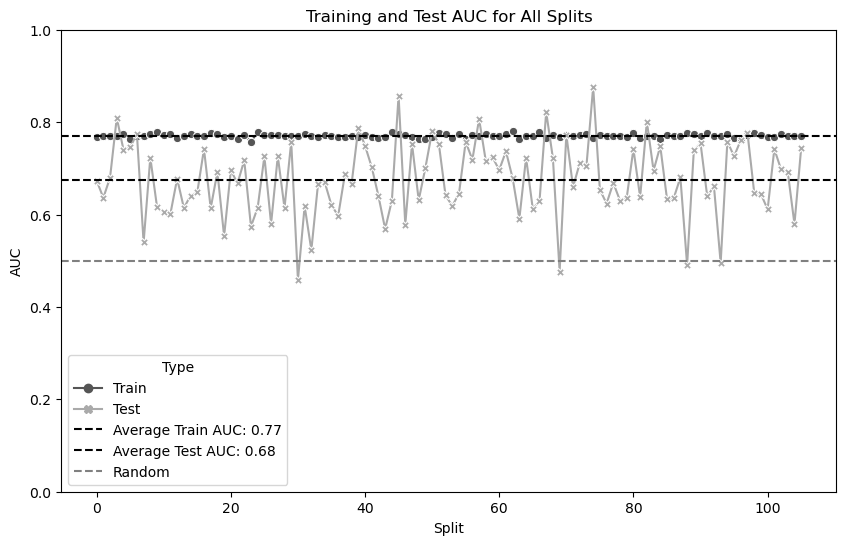

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'train_aucs' and 'test_aucs' are lists of AUC scores
splits = np.arange(len(train_aucs))  # Assuming splits are sequential and equal to the length of AUC lists

# Prepare a DataFrame for Seaborn
data = pd.DataFrame({
    'Split': np.concatenate([splits, splits]),  # Double the splits for train and test
    'AUC': np.concatenate([train_aucs, test_aucs]),  # Combine AUC scores
    'Type': ['Train']*len(train_aucs) + ['Test']*len(test_aucs)  # Label types
})

# Calculate the average values for training and test AUCs
avg_train_auc = sum(train_aucs) / len(train_aucs)
avg_test_auc = sum(test_aucs) / len(test_aucs)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Set the color palette to black and white
palette = sns.color_palette("gray", n_colors=2)

# Draw a line plot with Seaborn
sns.lineplot(data=data, x='Split', y='AUC', hue='Type', style='Type', markers=True, dashes=False, palette=palette)

# Add average lines for Train and Test AUCs
plt.axhline(y=avg_train_auc, color='black', linestyle='--', label=f"Average Train AUC: {avg_train_auc:.2f}")
plt.axhline(y=avg_test_auc, color='black', linestyle='--', label=f"Average Test AUC: {avg_test_auc:.2f}")

# Line for random chance performance
plt.axhline(y=0.5, color='gray', linestyle='--', label="Random")

# Customize the axes and title
plt.xlabel('Split')
plt.ylabel('AUC')
plt.title('Training and Test AUC for All Splits')

# Show the legend and customize it to not show the color guide
plt.legend(title='Type')

# Set the ylim to standardize the AUC view
plt.ylim([0, 1])

# Display the plot
plt.show()


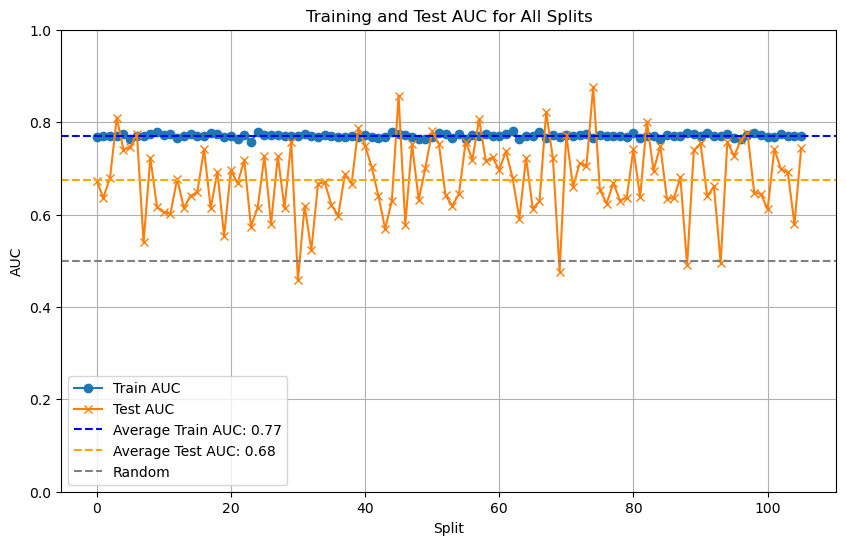

In [19]:
import matplotlib.pyplot as plt

# Calculate the average values for training and test AUCs
avg_train_auc = sum(train_aucs) / len(train_aucs)
avg_test_auc = sum(test_aucs) / len(test_aucs)

plt.figure(figsize=(10, 6))
plt.plot(train_aucs, label="Train AUC", marker='o')
plt.plot(test_aucs, label="Test AUC", marker='x')

# Add average lines for Train and Test AUCs
plt.axhline(y=avg_train_auc, color='blue', linestyle='--', label=f"Average Train AUC: {avg_train_auc:.2f}")
plt.axhline(y=avg_test_auc, color='orange', linestyle='--', label=f"Average Test AUC: {avg_test_auc:.2f}")

# Line for random
plt.axhline(y=0.5, color='gray', linestyle='--', label="Random")

plt.xlabel('Split')
plt.ylabel('AUC')
plt.title('Training and Test AUC for All Splits')
plt.legend()
plt.grid(True)
plt.ylim([0, 1])
plt.show()
